In [ ]:
!nvidia-smi

Fri Aug 13 08:11:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=c7fd73f649bfd41c22b83e24f3d68b9016899b397080e7f6bb0dcfd757afd2cd
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c severstal-steel-defect-detection

 99% 1.56G/1.57G [00:12<00:00, 151MB/s]
100% 1.57G/1.57G [00:13<00:00, 129MB/s]


In [ ]:
!unzip severstal-steel-defect-detection.zip

In [ ]:
pip install pretrainedmodels

In [ ]:
pip install segmentation-models-pytorch

# **TRAINING MODEL**

In [ ]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
from segmentation_models_pytorch import Unet
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [ ]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    # df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ImageId'] = df['ImageId']
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [ ]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

## **Model Initialization**

In [ ]:
model = Unet("resnet50", encoder_weights="imagenet", classes=4, activation=None)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## **Training and Validation**

In [ ]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type('torch.FloatTensor')
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "/content/drive/MyDrive/Colab Notebooks/my_projects/SteelDefectDetection/model_unet_resnet50.pth")
            print()

In [ ]:
sample_submission_path = 'Steel_defect_detection/sample_submission.csv'
train_df_path = 'Steel_defect_detection/train.csv'
data_folder = 'Steel_defect_detection/'
test_data_folder = 'Steel_defect_detection/test_images'

In [ ]:
!pip install timm

In [ ]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 08:21:47


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9724603950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDat

Loss: 0.1982 | IoU: 0.1074 | dice: 0.1491 | dice_neg: nan | dice_pos: 0.1491
Starting epoch: 0 | phase: val | ⏰: 08:31:34
Loss: 0.0489 | IoU: 0.3104 | dice: 0.4109 | dice_neg: nan | dice_pos: 0.4109
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 08:32:45
Loss: 0.0404 | IoU: 0.3109 | dice: 0.4059 | dice_neg: nan | dice_pos: 0.4059
Starting epoch: 1 | phase: val | ⏰: 08:42:32
Loss: 0.0325 | IoU: 0.3054 | dice: 0.3976 | dice_neg: nan | dice_pos: 0.3976
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 08:43:38
Loss: 0.0317 | IoU: 0.3357 | dice: 0.4296 | dice_neg: nan | dice_pos: 0.4296
Starting epoch: 2 | phase: val | ⏰: 08:53:26
Loss: 0.0291 | IoU: 0.3508 | dice: 0.4457 | dice_neg: nan | dice_pos: 0.4457
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 08:54:32
Loss: 0.0284 | IoU: 0.3457 | dice: 0.4400 | dice_neg: nan | dice_pos: 0.4400
Starting epoch: 3 | phase: val |

# **PLOT TRAINING RESULT**



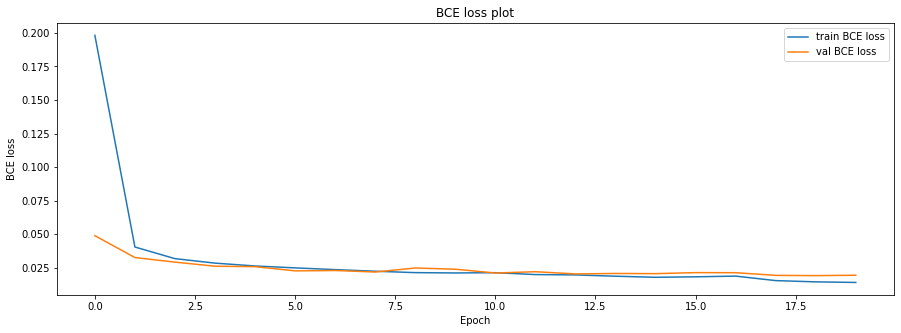

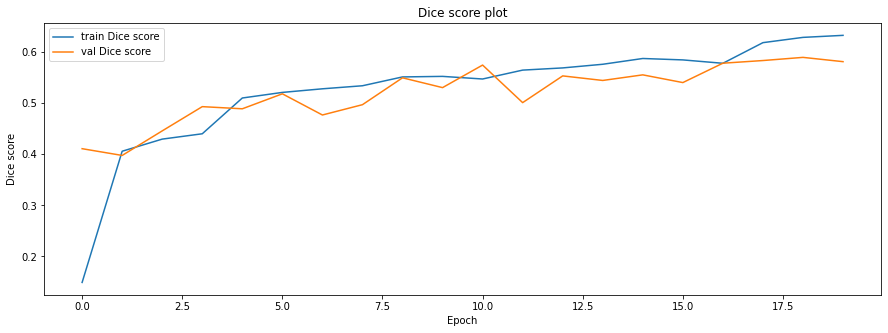

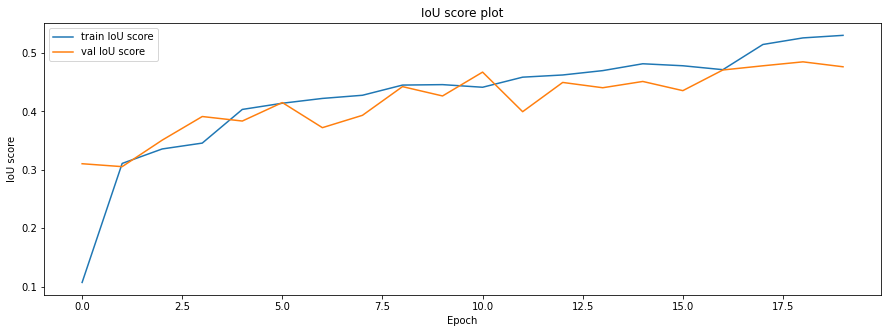

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

# **INFERENCE**

In [ ]:
### Inference

import pdb
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Normalize, Compose)
from albumentations.torch import ToTensor
import torch.utils.data as data
from segmentation_models_pytorch import Unet

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        # df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [ ]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
sample_submission_path = 'Steel_defect_detection/sample_submission.csv'
test_data_folder = "Steel_defect_detection/test_images"

In [ ]:
# initialize test dataloader
best_threshold = 0.4
num_workers = 2
batch_size = 10
print('best_threshold', best_threshold)
min_size = 3500
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

best_threshold 0.4


In [ ]:
# Initialize model and load trained weights
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/my_projects/SteelDefectDetection/model_unet_resnet50.pth"
device = torch.device("cuda")
model = Unet("resnet50", encoder_weights=None, classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [ ]:
# start prediction
count = 0
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        count += 1
        print("fname: ", fname)
        for cls, pred in enumerate(preds):
            # print('cls: ', cls)
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            if len(rle) == 0:
              continue
            # print("Len rle: ", len(rle))
            name = fname
            cls_id = cls + 1
            predictions.append([name, rle, cls_id])
    # print(predictions)
    # break
# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId','EncodedPixels', 'ClassId'])

 23%|██▎       | 128/551 [00:49<02:40,  2.63it/s]

fname:  3c9691d0c.jpg
fname:  3ca7b5258.jpg
fname:  3cabac622.jpg
fname:  3cc137693.jpg
fname:  3cc977045.jpg
fname:  3ccce52ca.jpg
fname:  3cd6ac535.jpg
fname:  3cda89859.jpg
fname:  3cdc887ce.jpg
fname:  3ce66d6da.jpg


 23%|██▎       | 129/551 [00:50<02:40,  2.63it/s]

fname:  3cea1b62e.jpg
fname:  3cee96935.jpg
fname:  3cfa60f2d.jpg
fname:  3cfda2739.jpg
fname:  3d0061371.jpg
fname:  3d060ac2d.jpg
fname:  3d0ea6368.jpg
fname:  3d24f9bc4.jpg
fname:  3d2738235.jpg
fname:  3d27c410a.jpg


 24%|██▎       | 130/551 [00:50<02:39,  2.65it/s]

fname:  3d40518d7.jpg
fname:  3d4c5361e.jpg
fname:  3d5d18f9b.jpg
fname:  3d6211a2f.jpg
fname:  3d67a43c7.jpg
fname:  3d68c28a5.jpg
fname:  3d6d3b4e1.jpg
fname:  3d726e453.jpg
fname:  3d8b0c82c.jpg
fname:  3d8c0069f.jpg


 24%|██▍       | 131/551 [00:50<02:38,  2.65it/s]

fname:  3d95c6d0e.jpg
fname:  3d9bbdf3e.jpg
fname:  3da41c9f0.jpg
fname:  3dac7e059.jpg
fname:  3daf2ff8e.jpg
fname:  3db5f1334.jpg
fname:  3dbf3fa5e.jpg
fname:  3dc2e6b24.jpg
fname:  3dd0c0c92.jpg
fname:  3de36e290.jpg


 24%|██▍       | 132/551 [00:51<02:38,  2.64it/s]

fname:  3de4313ab.jpg
fname:  3df07d378.jpg
fname:  3df222f6a.jpg
fname:  3dfa71d0d.jpg
fname:  3e1b9d319.jpg
fname:  3e33ab363.jpg
fname:  3e3453f2b.jpg
fname:  3e430ace5.jpg
fname:  3e454f45c.jpg
fname:  3e48dbdef.jpg


 24%|██▍       | 133/551 [00:51<02:38,  2.63it/s]

fname:  3e49a04a2.jpg
fname:  3e51590f0.jpg
fname:  3e54c62c3.jpg
fname:  3e6c0f7a4.jpg
fname:  3e74521f8.jpg
fname:  3e7ba0552.jpg
fname:  3e819b6c2.jpg
fname:  3e9a242e0.jpg
fname:  3e9d6f8cc.jpg
fname:  3ea5ee677.jpg


 24%|██▍       | 134/551 [00:51<02:41,  2.58it/s]

fname:  3ec25e3fe.jpg
fname:  3ecd7753b.jpg
fname:  3ecf2d5ba.jpg
fname:  3ee3a7b9e.jpg
fname:  3eed82d4e.jpg
fname:  3ef60f89b.jpg
fname:  3ef971a0e.jpg
fname:  3f0e0a371.jpg
fname:  3f17e4acc.jpg
fname:  3f202b2ce.jpg


 25%|██▍       | 135/551 [00:52<02:40,  2.59it/s]

fname:  3f208371f.jpg
fname:  3f2934fdd.jpg
fname:  3f367b9b3.jpg
fname:  3f4ec1f44.jpg
fname:  3f612c53c.jpg
fname:  3f6145c7d.jpg
fname:  3f62cb71d.jpg
fname:  3f692ff67.jpg
fname:  3f71f1d7b.jpg
fname:  3f8db1db5.jpg


 25%|██▍       | 136/551 [00:52<02:38,  2.62it/s]

fname:  3f9314e1d.jpg
fname:  3fa703839.jpg
fname:  3fa9e440d.jpg
fname:  3fae96c5b.jpg
fname:  3fb5b0b1f.jpg
fname:  3fb623a56.jpg
fname:  3fcbe5470.jpg
fname:  3fd2ab3cd.jpg
fname:  3fd94ce7f.jpg
fname:  3fdb61716.jpg


 25%|██▍       | 137/551 [00:53<02:37,  2.63it/s]

fname:  3fe19e33d.jpg
fname:  3ff293de1.jpg
fname:  3ff49ae6a.jpg
fname:  4012264aa.jpg
fname:  4013437f9.jpg
fname:  4016a4be2.jpg
fname:  40350cf8f.jpg
fname:  4046be032.jpg
fname:  40485bc6c.jpg
fname:  40607558c.jpg


 25%|██▌       | 138/551 [00:53<02:34,  2.67it/s]

fname:  406815810.jpg
fname:  407338e32.jpg
fname:  40768debb.jpg
fname:  407d43dae.jpg
fname:  4080b4d05.jpg
fname:  40b97ac12.jpg
fname:  40bcf7d16.jpg
fname:  40be39e44.jpg
fname:  40c8de4ab.jpg
fname:  40cce4934.jpg


 25%|██▌       | 139/551 [00:53<02:33,  2.68it/s]

fname:  40e764274.jpg
fname:  40f8087ac.jpg
fname:  40fabb078.jpg
fname:  411a144a2.jpg
fname:  412633edb.jpg
fname:  413460984.jpg
fname:  4136f24a9.jpg
fname:  413e0cb98.jpg
fname:  4141bd746.jpg
fname:  414d96788.jpg


 25%|██▌       | 140/551 [00:54<02:33,  2.68it/s]

fname:  415539856.jpg
fname:  418b7376c.jpg
fname:  418bf2729.jpg
fname:  41967d8d7.jpg
fname:  41a30e16c.jpg
fname:  41b6aea5e.jpg
fname:  41bbd1076.jpg
fname:  41cbfc016.jpg
fname:  41e4c4550.jpg
fname:  41f51590f.jpg


 26%|██▌       | 141/551 [00:54<02:31,  2.70it/s]

fname:  41f81f578.jpg
fname:  420b68112.jpg
fname:  421f6e318.jpg
fname:  4222b0b1d.jpg
fname:  4223116c6.jpg
fname:  42234ac37.jpg
fname:  42333c57d.jpg
fname:  423a4531e.jpg
fname:  424516278.jpg
fname:  424b57fbe.jpg


 26%|██▌       | 142/551 [00:54<02:31,  2.70it/s]

fname:  42542bbe6.jpg
fname:  42636127e.jpg
fname:  4268b35d9.jpg
fname:  42795e53d.jpg
fname:  427b10b21.jpg
fname:  4291658ce.jpg
fname:  429a2d97a.jpg
fname:  429a6437d.jpg
fname:  42a7c4cd4.jpg
fname:  42aa6fd93.jpg


 26%|██▌       | 143/551 [00:55<02:32,  2.67it/s]

fname:  42ac758fc.jpg
fname:  42ae82ae2.jpg
fname:  42c3f7b08.jpg
fname:  42d4d28f6.jpg
fname:  42e6c728d.jpg
fname:  42f162eec.jpg
fname:  42f269efe.jpg
fname:  42f2b7c8e.jpg
fname:  43002ba30.jpg
fname:  43129c346.jpg


 26%|██▌       | 144/551 [00:55<02:30,  2.70it/s]

fname:  43174e99b.jpg
fname:  431a9ccc3.jpg
fname:  431e86caa.jpg
fname:  431ef181d.jpg
fname:  432cc82fe.jpg
fname:  4333ec468.jpg
fname:  4337d169a.jpg
fname:  433ecc86d.jpg
fname:  43440f039.jpg
fname:  43558fbec.jpg


 26%|██▋       | 145/551 [00:56<02:29,  2.72it/s]

fname:  435e66b3a.jpg
fname:  4360329d0.jpg
fname:  437271da1.jpg
fname:  438ad7d10.jpg
fname:  439133dbf.jpg
fname:  439973eed.jpg
fname:  439feac51.jpg
fname:  43a10ca4f.jpg
fname:  43a20b18b.jpg
fname:  43b0dec37.jpg


 26%|██▋       | 146/551 [00:56<02:29,  2.71it/s]

fname:  43b6a6a1a.jpg
fname:  43be155b2.jpg
fname:  43c1a4a70.jpg
fname:  43cdf7d8d.jpg
fname:  43d3e6f33.jpg
fname:  43e98ae7e.jpg
fname:  43fe37865.jpg
fname:  4425a3ca1.jpg
fname:  44398db54.jpg
fname:  443d3ddd0.jpg


 27%|██▋       | 147/551 [00:56<02:27,  2.74it/s]

fname:  44458e244.jpg
fname:  44529076b.jpg
fname:  4453800c1.jpg
fname:  445451d11.jpg
fname:  44578c960.jpg
fname:  445a4f77f.jpg
fname:  446372a47.jpg
fname:  448546cd8.jpg
fname:  44859b1b9.jpg
fname:  448a73204.jpg


 27%|██▋       | 148/551 [00:57<02:27,  2.74it/s]

fname:  4490e43c1.jpg
fname:  44a556271.jpg
fname:  44a5dd5b9.jpg
fname:  44a665c86.jpg
fname:  44aca2961.jpg
fname:  44bbde24d.jpg
fname:  44c959096.jpg
fname:  44ca85273.jpg
fname:  44d5951f6.jpg
fname:  44d86ff71.jpg


 27%|██▋       | 149/551 [00:57<02:26,  2.74it/s]

fname:  44ebc9b9c.jpg
fname:  450ae93ff.jpg
fname:  450e4bd18.jpg
fname:  451e723f9.jpg
fname:  454d8aab4.jpg
fname:  454f1f49f.jpg
fname:  45603a958.jpg
fname:  456241aa5.jpg
fname:  457e96b39.jpg
fname:  457fc48b6.jpg


 27%|██▋       | 150/551 [00:57<02:27,  2.72it/s]

fname:  45b112be2.jpg
fname:  45cb7a530.jpg
fname:  45d3107a6.jpg
fname:  45da4ba4e.jpg
fname:  45e5a37d9.jpg
fname:  46005280a.jpg
fname:  461244df0.jpg
fname:  462ed8877.jpg
fname:  46490d7cf.jpg
fname:  465d8df45.jpg


 27%|██▋       | 151/551 [00:58<02:28,  2.70it/s]

fname:  465fc25a2.jpg
fname:  467e97477.jpg
fname:  468b52dfd.jpg
fname:  469ed0fd8.jpg
fname:  46a3d5669.jpg
fname:  46aa8fef0.jpg
fname:  46ab71946.jpg
fname:  46b63e8e6.jpg
fname:  46b8a3c36.jpg
fname:  46bd2aedc.jpg


 28%|██▊       | 152/551 [00:58<02:26,  2.72it/s]

fname:  46d2424e8.jpg
fname:  46effeaf6.jpg
fname:  470055e36.jpg
fname:  470c1f76e.jpg
fname:  470da814d.jpg
fname:  47196f3d0.jpg
fname:  4724b83ae.jpg
fname:  4731631cd.jpg
fname:  4734df616.jpg
fname:  474097219.jpg


 28%|██▊       | 153/551 [00:58<02:25,  2.74it/s]

fname:  4742aaf6c.jpg
fname:  4752c59a6.jpg
fname:  475d8e8d6.jpg
fname:  47608300f.jpg
fname:  4778df12c.jpg
fname:  477cc1c37.jpg
fname:  47890fdf1.jpg
fname:  47905a92b.jpg
fname:  479467fe1.jpg
fname:  47a65c929.jpg


 28%|██▊       | 154/551 [00:59<02:24,  2.75it/s]

fname:  47a821dca.jpg
fname:  47b4b7309.jpg
fname:  47c1a0f4a.jpg
fname:  47c9178a3.jpg
fname:  47e238c2b.jpg
fname:  47e2c3429.jpg
fname:  47f0dff6c.jpg
fname:  47fb40e7a.jpg
fname:  4806661d7.jpg
fname:  4822f7455.jpg


 28%|██▊       | 155/551 [00:59<02:22,  2.77it/s]

fname:  483aa8d9e.jpg
fname:  484944caa.jpg
fname:  485195199.jpg
fname:  486e31a14.jpg
fname:  48739c768.jpg
fname:  487772f8c.jpg
fname:  48786fbac.jpg
fname:  4881c073e.jpg
fname:  48843943f.jpg
fname:  488f20b5b.jpg


 28%|██▊       | 156/551 [01:00<02:22,  2.78it/s]

fname:  4894c05e2.jpg
fname:  48994af29.jpg
fname:  489af01cc.jpg
fname:  48b838a22.jpg
fname:  48c11ff86.jpg
fname:  48c23125e.jpg
fname:  48c2fa29f.jpg
fname:  48c3f3058.jpg
fname:  48d624a89.jpg
fname:  48e20d67f.jpg


 28%|██▊       | 157/551 [01:00<02:23,  2.75it/s]

fname:  48edc93aa.jpg
fname:  491f3c085.jpg
fname:  49206b475.jpg
fname:  49289e055.jpg
fname:  492e3ed43.jpg
fname:  492f6c44a.jpg
fname:  4931bdcff.jpg
fname:  49420e583.jpg
fname:  49473a647.jpg
fname:  496b539bf.jpg


 29%|██▊       | 158/551 [01:00<02:24,  2.72it/s]

fname:  4985959b6.jpg
fname:  49881d3ac.jpg
fname:  499a9893b.jpg
fname:  499b84670.jpg
fname:  499e41bff.jpg
fname:  49a275291.jpg
fname:  49a386da3.jpg
fname:  49b1c08c6.jpg
fname:  49b82cbb6.jpg
fname:  49d7ee139.jpg


 29%|██▉       | 159/551 [01:01<02:24,  2.70it/s]

fname:  49e22bae6.jpg
fname:  49e26e878.jpg
fname:  49e4b8bf4.jpg
fname:  49ee7d5d6.jpg
fname:  4a1aa2afb.jpg
fname:  4a206c588.jpg
fname:  4a7880215.jpg
fname:  4a7a588aa.jpg
fname:  4a7d06ee3.jpg
fname:  4a84c317a.jpg


 29%|██▉       | 160/551 [01:01<02:24,  2.70it/s]

fname:  4a967c042.jpg
fname:  4a96ab59b.jpg
fname:  4a9ea3b15.jpg
fname:  4aa179bf3.jpg
fname:  4ab23743e.jpg
fname:  4accf83d2.jpg
fname:  4ad8ea918.jpg
fname:  4ae9f7578.jpg
fname:  4aea652c4.jpg
fname:  4aea81288.jpg


 29%|██▉       | 161/551 [01:01<02:23,  2.71it/s]

fname:  4af55bec7.jpg
fname:  4b12a77d9.jpg
fname:  4b2051e3a.jpg
fname:  4b26d267d.jpg
fname:  4b42e7bce.jpg
fname:  4b481e4e2.jpg
fname:  4b4ab7061.jpg
fname:  4b4fed977.jpg
fname:  4b50356da.jpg
fname:  4b623a56d.jpg


 29%|██▉       | 162/551 [01:02<02:24,  2.69it/s]

fname:  4b64a9310.jpg
fname:  4b6d44881.jpg
fname:  4b70a1ea7.jpg
fname:  4b74c6da8.jpg
fname:  4b8bb2c7a.jpg
fname:  4ba42db74.jpg
fname:  4ba69ef7d.jpg
fname:  4baf21c1f.jpg
fname:  4bd2bb1d1.jpg
fname:  4c01904bd.jpg


 30%|██▉       | 163/551 [01:02<02:24,  2.68it/s]

fname:  4c172fe9b.jpg
fname:  4c201e836.jpg
fname:  4c27e754f.jpg
fname:  4c35eb6bf.jpg
fname:  4c394663d.jpg
fname:  4c3feb803.jpg
fname:  4c4394609.jpg
fname:  4c501d173.jpg
fname:  4c517c179.jpg
fname:  4c5671c92.jpg


 30%|██▉       | 164/551 [01:03<02:23,  2.69it/s]

fname:  4c63aa5c5.jpg
fname:  4c6a757c4.jpg
fname:  4c6e9a744.jpg
fname:  4c7d0c617.jpg
fname:  4c805698a.jpg
fname:  4c8b77164.jpg
fname:  4c94b8945.jpg
fname:  4cb7d6be7.jpg
fname:  4cbbc8782.jpg
fname:  4ccf578d8.jpg


 30%|██▉       | 165/551 [01:03<02:22,  2.71it/s]

fname:  4ce10785d.jpg
fname:  4ce6b0ff9.jpg
fname:  4cfe7df3f.jpg
fname:  4cff228ec.jpg
fname:  4d15569e3.jpg
fname:  4d1d9a35d.jpg
fname:  4d33bf863.jpg
fname:  4d429c29f.jpg
fname:  4d47bbee9.jpg
fname:  4d74b499a.jpg


 30%|███       | 166/551 [01:03<02:21,  2.72it/s]

fname:  4d867efc2.jpg
fname:  4d8ad1be5.jpg
fname:  4d9155ef0.jpg
fname:  4db83ad8d.jpg
fname:  4dbe9e54b.jpg
fname:  4dc0acaf8.jpg
fname:  4dd2b157f.jpg
fname:  4ddbed78c.jpg
fname:  4dde69bdb.jpg
fname:  4df206f87.jpg


 30%|███       | 167/551 [01:04<02:20,  2.74it/s]

fname:  4e0891122.jpg
fname:  4e0b35223.jpg
fname:  4e10602bf.jpg
fname:  4e287cf65.jpg
fname:  4e2d3e684.jpg
fname:  4e48fbcf7.jpg
fname:  4e5c4ab98.jpg
fname:  4e6339bd8.jpg
fname:  4e6d9448e.jpg
fname:  4e8309017.jpg


 30%|███       | 168/551 [01:04<02:20,  2.73it/s]

fname:  4e83bb356.jpg
fname:  4e96ca29e.jpg
fname:  4ea6093c2.jpg
fname:  4ea7db587.jpg
fname:  4eb80af64.jpg
fname:  4ebedb378.jpg
fname:  4ec49a3bb.jpg
fname:  4ecc35d73.jpg
fname:  4eceaf349.jpg
fname:  4edbc69c9.jpg


 31%|███       | 169/551 [01:04<02:19,  2.74it/s]

fname:  4ee9be91a.jpg
fname:  4efaced22.jpg
fname:  4f0516a6d.jpg
fname:  4f102c0cf.jpg
fname:  4f1b62ebc.jpg
fname:  4f1f11765.jpg
fname:  4f324ba00.jpg
fname:  4f3a1fccf.jpg
fname:  4f3f3e724.jpg
fname:  4f42954dd.jpg


 31%|███       | 170/551 [01:05<02:18,  2.74it/s]

fname:  4f6b16455.jpg
fname:  4f78756bc.jpg
fname:  4f8180689.jpg
fname:  4f84396bf.jpg
fname:  4f89f5c82.jpg
fname:  4fbfb2d31.jpg
fname:  4fc5e354f.jpg
fname:  4fc700b09.jpg
fname:  4fd6d8734.jpg
fname:  4fdd51899.jpg


 31%|███       | 171/551 [01:05<02:19,  2.72it/s]

fname:  4fe01ee43.jpg
fname:  5006a583f.jpg
fname:  5012e0ae6.jpg
fname:  501425ab6.jpg
fname:  50254820b.jpg
fname:  502abdb3e.jpg
fname:  5030c3a6b.jpg
fname:  50377feca.jpg
fname:  5053f8652.jpg
fname:  505aa7ab2.jpg


 31%|███       | 172/551 [01:05<02:18,  2.73it/s]

fname:  50682c970.jpg
fname:  5071f2fea.jpg
fname:  507273e89.jpg
fname:  508412e33.jpg
fname:  50a744777.jpg
fname:  50a8edad1.jpg
fname:  50ab678de.jpg
fname:  50ab78bea.jpg
fname:  50af3b62e.jpg
fname:  50e1cd534.jpg


 31%|███▏      | 173/551 [01:06<02:19,  2.70it/s]

fname:  50e53e7c3.jpg
fname:  50f3302b8.jpg
fname:  50f7c2966.jpg
fname:  512652b4f.jpg
fname:  5143357e4.jpg
fname:  5144b32b4.jpg
fname:  515fe06c0.jpg
fname:  5172f2c58.jpg
fname:  51791df89.jpg
fname:  517fffea8.jpg


 32%|███▏      | 174/551 [01:06<02:18,  2.73it/s]

fname:  5199a0874.jpg
fname:  51b14c5a5.jpg
fname:  51c6bfed8.jpg
fname:  51d567eeb.jpg
fname:  51dcb8f33.jpg
fname:  51f5160e9.jpg
fname:  52112473e.jpg
fname:  5216c1a71.jpg
fname:  5218d8778.jpg
fname:  521fa9d13.jpg


 32%|███▏      | 175/551 [01:07<02:17,  2.73it/s]

fname:  5220f7a0d.jpg
fname:  522b748ce.jpg
fname:  522cba85f.jpg
fname:  5253b3543.jpg
fname:  525fa7aba.jpg
fname:  5260bbf25.jpg
fname:  526c07e1d.jpg
fname:  527fe84ed.jpg
fname:  5285af262.jpg
fname:  528a42ce5.jpg


 32%|███▏      | 176/551 [01:07<02:17,  2.74it/s]

fname:  528c7a307.jpg
fname:  529087e45.jpg
fname:  52a92951f.jpg
fname:  52bef8669.jpg
fname:  52c1ea3b8.jpg
fname:  52c9e988e.jpg
fname:  52d25bedf.jpg
fname:  52d2d63ae.jpg
fname:  52d505bc0.jpg
fname:  52d57df7a.jpg


 32%|███▏      | 177/551 [01:07<02:16,  2.74it/s]

fname:  52e19ee35.jpg
fname:  52ec4de37.jpg
fname:  5304fec87.jpg
fname:  5313ddcb2.jpg
fname:  531cfc800.jpg
fname:  532145e5c.jpg
fname:  532213183.jpg
fname:  532c4b959.jpg
fname:  532d65f46.jpg
fname:  53499ccef.jpg


 32%|███▏      | 178/551 [01:08<02:17,  2.71it/s]

fname:  534f1aade.jpg
fname:  5352fa0c9.jpg
fname:  53592ec18.jpg
fname:  53608083c.jpg
fname:  536437776.jpg
fname:  53660ffd5.jpg
fname:  538d8494e.jpg
fname:  5390e12f2.jpg
fname:  539b15315.jpg
fname:  53b4a04bd.jpg


 32%|███▏      | 179/551 [01:08<02:20,  2.65it/s]

fname:  53b81074e.jpg
fname:  53c0ccba7.jpg
fname:  53d47929e.jpg
fname:  53d4e26aa.jpg
fname:  53e0c92cf.jpg
fname:  53f3ec9be.jpg
fname:  53ffd9993.jpg
fname:  5405271e1.jpg
fname:  5406c01d7.jpg
fname:  5409d111f.jpg


 33%|███▎      | 180/551 [01:08<02:21,  2.62it/s]

fname:  540b42c78.jpg
fname:  541141070.jpg
fname:  541e5bfec.jpg
fname:  5435c902a.jpg
fname:  543aaa6e1.jpg
fname:  544390b56.jpg
fname:  544553680.jpg
fname:  544f5beba.jpg
fname:  549c3c94d.jpg
fname:  549fb29f7.jpg


 33%|███▎      | 181/551 [01:09<02:19,  2.66it/s]

fname:  54a757589.jpg
fname:  54b3149e2.jpg
fname:  54babbc7b.jpg
fname:  54c862a0d.jpg
fname:  54d3df55b.jpg
fname:  54e77261b.jpg
fname:  54eb4b690.jpg
fname:  5500d78ed.jpg
fname:  550181692.jpg
fname:  552cc3cd2.jpg


 33%|███▎      | 182/551 [01:09<02:17,  2.68it/s]

fname:  55532901c.jpg
fname:  555917097.jpg
fname:  555fb5775.jpg
fname:  55727a004.jpg
fname:  5575ead92.jpg
fname:  559759f28.jpg
fname:  559aceb9e.jpg
fname:  559b07937.jpg
fname:  55a3fbe8b.jpg
fname:  55b1a1e8c.jpg


 33%|███▎      | 183/551 [01:10<02:16,  2.70it/s]

fname:  55b6b0853.jpg
fname:  55b9d15d5.jpg
fname:  55c686c1c.jpg
fname:  55cf360ba.jpg
fname:  55d32e8f3.jpg
fname:  55dfd6590.jpg
fname:  560b070fe.jpg
fname:  560c84cc8.jpg
fname:  561361cb6.jpg
fname:  56160f9ed.jpg


 33%|███▎      | 184/551 [01:10<02:15,  2.71it/s]

fname:  561cc13fd.jpg
fname:  56228a7ce.jpg
fname:  563c82165.jpg
fname:  5665d0780.jpg
fname:  56833978c.jpg
fname:  56899a1a5.jpg
fname:  569054fe5.jpg
fname:  56a22c123.jpg
fname:  56bd7c605.jpg
fname:  56bdb9e3c.jpg


 34%|███▎      | 185/551 [01:10<02:17,  2.66it/s]

fname:  56c03fa06.jpg
fname:  56d3153f9.jpg
fname:  56d707102.jpg
fname:  56db0da36.jpg
fname:  56f1af1f3.jpg
fname:  56f6544aa.jpg
fname:  56fe04b70.jpg
fname:  570949932.jpg
fname:  5712b3846.jpg
fname:  571717724.jpg


 34%|███▍      | 186/551 [01:11<02:16,  2.67it/s]

fname:  571c8299c.jpg
fname:  571eb97b3.jpg
fname:  573d1f811.jpg
fname:  574d67053.jpg
fname:  574f43979.jpg
fname:  5751be350.jpg
fname:  57650f6fe.jpg
fname:  576f80bf8.jpg
fname:  578dc421a.jpg
fname:  579d97368.jpg


 34%|███▍      | 187/551 [01:11<02:14,  2.70it/s]

fname:  57b1d7f73.jpg
fname:  57bd3ab37.jpg
fname:  57cabd349.jpg
fname:  57d4f4467.jpg
fname:  57ec0b110.jpg
fname:  57ff05dc1.jpg
fname:  58088b30a.jpg
fname:  58122fe14.jpg
fname:  5829668fc.jpg
fname:  582aa5194.jpg


 34%|███▍      | 188/551 [01:11<02:15,  2.69it/s]

fname:  583d01b09.jpg
fname:  58540918c.jpg
fname:  585774b65.jpg
fname:  5867aed54.jpg
fname:  587a9b3b2.jpg
fname:  587aa203b.jpg
fname:  588119a67.jpg
fname:  5881270f8.jpg
fname:  5892b97a9.jpg
fname:  5895de1c3.jpg


 34%|███▍      | 189/551 [01:12<02:15,  2.67it/s]

fname:  58986e16d.jpg
fname:  589dd7157.jpg
fname:  58a4013d8.jpg
fname:  58ab08172.jpg
fname:  58acb9b30.jpg
fname:  58de7641c.jpg
fname:  58e7a9529.jpg
fname:  58f22628e.jpg
fname:  58f6093db.jpg
fname:  58fbd1a0d.jpg


 34%|███▍      | 190/551 [01:12<02:15,  2.66it/s]

fname:  5900ac269.jpg
fname:  590aa4bfc.jpg
fname:  5943020f6.jpg
fname:  5943b12cf.jpg
fname:  594556fb4.jpg
fname:  5945a8248.jpg
fname:  594bc49fd.jpg
fname:  595426f59.jpg
fname:  595bd6fcf.jpg
fname:  5976e13d9.jpg


 35%|███▍      | 191/551 [01:12<02:13,  2.70it/s]

fname:  5992b1f0d.jpg
fname:  5998eee37.jpg
fname:  599f73dd0.jpg
fname:  59a40ecca.jpg
fname:  59b42a129.jpg
fname:  59c0a3475.jpg
fname:  59c2fdc9e.jpg
fname:  59ed4aa3d.jpg
fname:  59eff5e14.jpg
fname:  5a0ce7a50.jpg


 35%|███▍      | 192/551 [01:13<02:12,  2.70it/s]

fname:  5a1b85353.jpg
fname:  5a25d5a5c.jpg
fname:  5a2f952d9.jpg
fname:  5a6cc72c5.jpg
fname:  5a72c9adc.jpg
fname:  5a7c94126.jpg
fname:  5a9149cad.jpg
fname:  5a9444ea9.jpg
fname:  5a9a84c90.jpg
fname:  5aa035361.jpg


 35%|███▌      | 193/551 [01:13<02:11,  2.72it/s]

fname:  5aa3780c6.jpg
fname:  5aac82fa3.jpg
fname:  5aacbd81b.jpg
fname:  5abda8a7d.jpg
fname:  5ae4f1314.jpg
fname:  5ae58f03b.jpg
fname:  5aed4bb1a.jpg
fname:  5afaa1617.jpg
fname:  5b0021aa9.jpg
fname:  5b13f920c.jpg


 35%|███▌      | 194/551 [01:14<02:10,  2.74it/s]

fname:  5b1668f62.jpg
fname:  5b1e65973.jpg
fname:  5b3a4b5ad.jpg
fname:  5b4743e28.jpg
fname:  5b4d84943.jpg
fname:  5b4e2745d.jpg
fname:  5b598c70c.jpg
fname:  5b6095b41.jpg
fname:  5b65a330b.jpg
fname:  5ba0fddcf.jpg


 35%|███▌      | 195/551 [01:14<02:10,  2.73it/s]

fname:  5ba25ce9e.jpg
fname:  5ba631a31.jpg
fname:  5bb3b7c79.jpg
fname:  5bbbd9386.jpg
fname:  5bbdf1b40.jpg
fname:  5bbf5aa3f.jpg
fname:  5bbfa24f4.jpg
fname:  5bc9ba9ab.jpg
fname:  5be7e3153.jpg
fname:  5bf50027a.jpg


 36%|███▌      | 196/551 [01:14<02:16,  2.60it/s]

fname:  5c0d080ae.jpg
fname:  5c0dade54.jpg
fname:  5c1d0f9fb.jpg
fname:  5c2e366c6.jpg
fname:  5c53cb0ac.jpg
fname:  5c5f05ecc.jpg
fname:  5c64a04ee.jpg
fname:  5c6d48548.jpg
fname:  5c6f6dd5d.jpg
fname:  5c6fdc38e.jpg


 36%|███▌      | 197/551 [01:15<02:13,  2.64it/s]

fname:  5c70c3c1c.jpg
fname:  5c7fe28bc.jpg
fname:  5c8696dc0.jpg
fname:  5c9df14bd.jpg
fname:  5cb601d72.jpg
fname:  5cd0e72de.jpg
fname:  5d0f53d39.jpg
fname:  5d2ff8441.jpg
fname:  5d304901c.jpg
fname:  5d47359d4.jpg


 36%|███▌      | 198/551 [01:15<02:11,  2.69it/s]

fname:  5d4744af7.jpg
fname:  5d4db1af1.jpg
fname:  5d5816fc1.jpg
fname:  5d6b4e143.jpg
fname:  5d7456755.jpg
fname:  5d787f403.jpg
fname:  5d80961c1.jpg
fname:  5d890a5f5.jpg
fname:  5d8c56f79.jpg
fname:  5d8ed2a33.jpg


 36%|███▌      | 199/551 [01:15<02:12,  2.66it/s]

fname:  5d990dafc.jpg
fname:  5d99e8568.jpg
fname:  5d9b7753a.jpg
fname:  5da555152.jpg
fname:  5da5cbfac.jpg
fname:  5da7403fb.jpg
fname:  5dac94ae8.jpg
fname:  5dca8cdfb.jpg
fname:  5dcf6ad07.jpg
fname:  5ddc3b702.jpg


 36%|███▋      | 200/551 [01:16<02:10,  2.68it/s]

fname:  5de7960ac.jpg
fname:  5df2a3586.jpg
fname:  5df43c09e.jpg
fname:  5dfcf07ea.jpg
fname:  5e0167c6a.jpg
fname:  5e02471c4.jpg
fname:  5e049970d.jpg
fname:  5e070a325.jpg
fname:  5e1c6b7da.jpg
fname:  5e23a5dd3.jpg


 36%|███▋      | 201/551 [01:16<02:09,  2.71it/s]

fname:  5e260337f.jpg
fname:  5e276bb2c.jpg
fname:  5e2e9fbed.jpg
fname:  5e30d0033.jpg
fname:  5e3dcbb32.jpg
fname:  5e45b4859.jpg
fname:  5e62ce535.jpg
fname:  5e6bfcc72.jpg
fname:  5e84e45f5.jpg
fname:  5eb2c8fbf.jpg


 37%|███▋      | 202/551 [01:17<02:08,  2.71it/s]

fname:  5ed971fa8.jpg
fname:  5ee27345a.jpg
fname:  5ee50e1bd.jpg
fname:  5ee9d291a.jpg
fname:  5ef208772.jpg
fname:  5ef5a701c.jpg
fname:  5f039c2bd.jpg
fname:  5f0696eb5.jpg
fname:  5f1308e91.jpg
fname:  5f1bfd13a.jpg


 37%|███▋      | 203/551 [01:17<02:07,  2.74it/s]

fname:  5f2f8397d.jpg
fname:  5f3a02515.jpg
fname:  5f3e05497.jpg
fname:  5f3fd3e51.jpg
fname:  5f5a9fbe2.jpg
fname:  5f5d3acd5.jpg
fname:  5f627b6b6.jpg
fname:  5f90c4021.jpg
fname:  5f945be05.jpg
fname:  5f9833ca6.jpg


 37%|███▋      | 204/551 [01:17<02:06,  2.74it/s]

fname:  5f9e63b94.jpg
fname:  5f9ef35fe.jpg
fname:  5fa5c747c.jpg
fname:  5ff740a19.jpg
fname:  60029e885.jpg
fname:  601346ad8.jpg
fname:  6016402f8.jpg
fname:  601fa71b9.jpg
fname:  6023b25e4.jpg
fname:  602af9e96.jpg


 37%|███▋      | 205/551 [01:18<02:07,  2.70it/s]

fname:  602da1387.jpg
fname:  60303e8e5.jpg
fname:  6037dcb23.jpg
fname:  604bc60db.jpg
fname:  604c09921.jpg
fname:  60506409c.jpg
fname:  605bd920f.jpg
fname:  607b16d51.jpg
fname:  608032d8e.jpg
fname:  60a92d2d9.jpg


 37%|███▋      | 206/551 [01:18<02:06,  2.72it/s]

fname:  60aeddfa4.jpg
fname:  60b2a4e95.jpg
fname:  60ca93e34.jpg
fname:  60d20e525.jpg
fname:  60dc13c8f.jpg
fname:  6100eba6e.jpg
fname:  6108d0184.jpg
fname:  611f72ff8.jpg
fname:  6121f632b.jpg
fname:  61243b268.jpg


 38%|███▊      | 207/551 [01:18<02:05,  2.74it/s]

fname:  612e78ee5.jpg
fname:  614c43fa9.jpg
fname:  6157fa8c0.jpg
fname:  616204216.jpg
fname:  616388941.jpg
fname:  618dbf55c.jpg
fname:  61a881e1e.jpg
fname:  61c4ca29e.jpg
fname:  61e98507d.jpg
fname:  61fc6d361.jpg


 38%|███▊      | 208/551 [01:19<02:05,  2.73it/s]

fname:  61ffc10bd.jpg
fname:  62072cd72.jpg
fname:  6208d6324.jpg
fname:  62111c98d.jpg
fname:  6217e70bf.jpg
fname:  6227835a7.jpg
fname:  622d08c0e.jpg
fname:  62329850d.jpg
fname:  623b8ca2f.jpg
fname:  623f66b73.jpg


 38%|███▊      | 209/551 [01:19<02:04,  2.74it/s]

fname:  62405baae.jpg
fname:  624e88b69.jpg
fname:  625821b3f.jpg
fname:  625985f9f.jpg
fname:  6260f710b.jpg
fname:  626ae5ecb.jpg
fname:  627b75778.jpg
fname:  628362e98.jpg
fname:  6285d8d58.jpg
fname:  6288fa541.jpg


 38%|███▊      | 210/551 [01:20<02:05,  2.72it/s]

fname:  629c72b55.jpg
fname:  62b6f5934.jpg
fname:  62b8787a4.jpg
fname:  62be5fb44.jpg
fname:  62c1f3d26.jpg
fname:  62c457660.jpg
fname:  62c87691b.jpg
fname:  62cb38612.jpg
fname:  62dac11bd.jpg
fname:  62f621a7b.jpg


 38%|███▊      | 211/551 [01:20<02:03,  2.74it/s]

fname:  63061a1ca.jpg
fname:  630bed641.jpg
fname:  6314dd5da.jpg
fname:  6316d0775.jpg
fname:  6329702c5.jpg
fname:  632d55c7c.jpg
fname:  635c52e1b.jpg
fname:  638c1ccaf.jpg
fname:  638cec26c.jpg
fname:  639f1d658.jpg


 38%|███▊      | 212/551 [01:20<02:03,  2.74it/s]

fname:  63a381f9c.jpg
fname:  63b4c5c2b.jpg
fname:  63bf4132b.jpg
fname:  63c6321df.jpg
fname:  63d096591.jpg
fname:  63e619100.jpg
fname:  63e8fd4d7.jpg
fname:  63eccbd9a.jpg
fname:  63f794e33.jpg
fname:  63f7b3a5f.jpg


 39%|███▊      | 213/551 [01:21<02:02,  2.76it/s]

fname:  6401b4e8b.jpg
fname:  641175d57.jpg
fname:  641d49f77.jpg
fname:  641d5aa44.jpg
fname:  64273b706.jpg
fname:  6437b230a.jpg
fname:  644178023.jpg
fname:  644707b9b.jpg
fname:  644a6db9a.jpg
fname:  6463cc692.jpg


 39%|███▉      | 214/551 [01:21<02:01,  2.77it/s]

fname:  646643cf3.jpg
fname:  6466d57b2.jpg
fname:  646d52bd6.jpg
fname:  64740e639.jpg
fname:  64754f077.jpg
fname:  64a125236.jpg
fname:  64a5153e0.jpg
fname:  64be1959f.jpg
fname:  64c0f4596.jpg
fname:  64cae9fbb.jpg


 39%|███▉      | 215/551 [01:21<02:02,  2.75it/s]

fname:  64d1f29e0.jpg
fname:  64dd56b9a.jpg
fname:  64e0c5535.jpg
fname:  64e741b4d.jpg
fname:  64fd0f766.jpg
fname:  650dc1057.jpg
fname:  651ddac0b.jpg
fname:  6537a9fac.jpg
fname:  6537c12e1.jpg
fname:  6548e970c.jpg


 39%|███▉      | 216/551 [01:22<02:03,  2.71it/s]

fname:  655f28956.jpg
fname:  656b2014f.jpg
fname:  656c235e7.jpg
fname:  656fd8ac7.jpg
fname:  657bc3dab.jpg
fname:  6583c7755.jpg
fname:  65847f83e.jpg
fname:  658cc2360.jpg
fname:  659351d6e.jpg
fname:  65a28f93e.jpg


 39%|███▉      | 217/551 [01:22<02:03,  2.70it/s]

fname:  65aeb5c2d.jpg
fname:  65bb87731.jpg
fname:  65de19b8e.jpg
fname:  65e0e85fc.jpg
fname:  663554e0a.jpg
fname:  663bc6085.jpg
fname:  665585fa7.jpg
fname:  66559fd84.jpg
fname:  665b0f161.jpg
fname:  666567e46.jpg


 40%|███▉      | 218/551 [01:22<02:03,  2.70it/s]

fname:  666ca7516.jpg
fname:  668152c3d.jpg
fname:  6682439cc.jpg
fname:  6686b7448.jpg
fname:  668fed093.jpg
fname:  66a2b6b8c.jpg
fname:  66c24365d.jpg
fname:  66d62df71.jpg
fname:  66e074eba.jpg
fname:  66e24b327.jpg


 40%|███▉      | 219/551 [01:23<02:02,  2.70it/s]

fname:  66e6f9fdb.jpg
fname:  66ec1cc9f.jpg
fname:  66f228f13.jpg
fname:  6709ad4ae.jpg
fname:  670dda82e.jpg
fname:  670f306c5.jpg
fname:  67276cbc3.jpg
fname:  674544933.jpg
fname:  674d0865d.jpg
fname:  674ecec48.jpg


 40%|███▉      | 220/551 [01:23<02:02,  2.69it/s]

fname:  67529c1c7.jpg
fname:  675747a8e.jpg
fname:  676518b85.jpg
fname:  676744197.jpg
fname:  676e41fea.jpg
fname:  6777f88a3.jpg
fname:  6785b89b5.jpg
fname:  678b2f283.jpg
fname:  679c7d8df.jpg
fname:  679e092e6.jpg


 40%|████      | 221/551 [01:24<02:00,  2.73it/s]

fname:  67a345551.jpg
fname:  67a48df5f.jpg
fname:  67e4f56ea.jpg
fname:  67f3733e1.jpg
fname:  67f4768b7.jpg
fname:  67f8b0f1b.jpg
fname:  67fa9b372.jpg
fname:  67fd6ce4d.jpg
fname:  681775be8.jpg
fname:  681d2c161.jpg


 40%|████      | 222/551 [01:24<02:00,  2.73it/s]

fname:  68281b5f0.jpg
fname:  684aabcc3.jpg
fname:  68510d353.jpg
fname:  68574541a.jpg
fname:  686ac1474.jpg
fname:  687c0d177.jpg
fname:  687fb3fb1.jpg
fname:  68970691d.jpg
fname:  68a86566f.jpg
fname:  68a8b4ff8.jpg


 40%|████      | 223/551 [01:24<01:59,  2.74it/s]

fname:  68afa072c.jpg
fname:  68ba10868.jpg
fname:  68ba3ef8c.jpg
fname:  68c89e9c2.jpg
fname:  68cc58d65.jpg
fname:  68d1c6f63.jpg
fname:  68d7d7a6d.jpg
fname:  68dae80a2.jpg
fname:  68ebba40c.jpg
fname:  68f152bb2.jpg


 41%|████      | 224/551 [01:25<01:59,  2.74it/s]

fname:  690fbb138.jpg
fname:  691a64f10.jpg
fname:  691c0cb65.jpg
fname:  694f1ac9f.jpg
fname:  695fe876d.jpg
fname:  6961c8b27.jpg
fname:  6974b3175.jpg
fname:  69813a9e5.jpg
fname:  698d16bfb.jpg
fname:  699159df8.jpg


 41%|████      | 225/551 [01:25<01:58,  2.75it/s]

fname:  69abec4f0.jpg
fname:  69b313a77.jpg
fname:  69b5d605e.jpg
fname:  69b6bf4d8.jpg
fname:  69bc8326c.jpg
fname:  69beeec9a.jpg
fname:  69c75598b.jpg
fname:  69d2fe769.jpg
fname:  69d691e69.jpg
fname:  69d9e3b5b.jpg


 41%|████      | 226/551 [01:25<01:58,  2.75it/s]

fname:  69f4515de.jpg
fname:  69f7a50a4.jpg
fname:  69fa9cb00.jpg
fname:  6a0229e31.jpg
fname:  6a054faac.jpg
fname:  6a080891e.jpg
fname:  6a1b98627.jpg
fname:  6a1ffbe59.jpg
fname:  6a2c1fa3d.jpg
fname:  6a2f44a67.jpg


 41%|████      | 227/551 [01:26<01:57,  2.76it/s]

fname:  6a38180d6.jpg
fname:  6a41e9c80.jpg
fname:  6a45da8e9.jpg
fname:  6a59795d3.jpg
fname:  6a73abf2d.jpg
fname:  6a746d53b.jpg
fname:  6a75462f9.jpg
fname:  6a7ef312c.jpg
fname:  6a98ce140.jpg
fname:  6a9924fe8.jpg


 41%|████▏     | 228/551 [01:26<01:58,  2.73it/s]

fname:  6ab065fba.jpg
fname:  6ac40e321.jpg
fname:  6ad0e93f3.jpg
fname:  6ad0fc82b.jpg
fname:  6ad67784c.jpg
fname:  6af0ca454.jpg
fname:  6af6c4335.jpg
fname:  6af785236.jpg
fname:  6b028ed80.jpg
fname:  6b2e438f1.jpg


 42%|████▏     | 229/551 [01:26<01:56,  2.76it/s]

fname:  6b3f45fc4.jpg
fname:  6b414548c.jpg
fname:  6b534290d.jpg
fname:  6b5b020e7.jpg
fname:  6b5c466a8.jpg
fname:  6b7864ff3.jpg
fname:  6b7dc5166.jpg
fname:  6b8090f1d.jpg
fname:  6b8b34d8a.jpg
fname:  6b92af39f.jpg


 42%|████▏     | 230/551 [01:27<01:56,  2.75it/s]

fname:  6b984a374.jpg
fname:  6b9d0b108.jpg
fname:  6bda73259.jpg
fname:  6bf294f5d.jpg
fname:  6bf4c86f1.jpg
fname:  6c0a9fe46.jpg
fname:  6c1621d11.jpg
fname:  6c1f9471a.jpg
fname:  6c26471b8.jpg
fname:  6c3361f5a.jpg


 42%|████▏     | 231/551 [01:27<01:57,  2.73it/s]

fname:  6c45a7db6.jpg
fname:  6c4b43ee0.jpg
fname:  6c5f141fc.jpg
fname:  6c6978dec.jpg
fname:  6c76d2dce.jpg
fname:  6c831f4d2.jpg
fname:  6c92395fc.jpg
fname:  6c972aef5.jpg
fname:  6c9db53a5.jpg
fname:  6cb33adca.jpg


 42%|████▏     | 232/551 [01:28<01:56,  2.74it/s]

fname:  6cb73e5f5.jpg
fname:  6cc1407fb.jpg
fname:  6cc6f6248.jpg
fname:  6cd1b07ca.jpg
fname:  6cd244b35.jpg
fname:  6ce149f0d.jpg
fname:  6ce80f81d.jpg
fname:  6ce9c205b.jpg
fname:  6cee97ec8.jpg
fname:  6cf74c1d9.jpg


 42%|████▏     | 233/551 [01:28<01:55,  2.76it/s]

fname:  6d0102129.jpg
fname:  6d0bcc474.jpg
fname:  6d0bd0a2d.jpg
fname:  6d1b0740c.jpg
fname:  6d1c2d227.jpg
fname:  6d23a589f.jpg
fname:  6d29df253.jpg
fname:  6d2a4005f.jpg
fname:  6d34dd2f9.jpg
fname:  6d422b814.jpg


 42%|████▏     | 234/551 [01:28<01:54,  2.76it/s]

fname:  6d422d496.jpg
fname:  6d478efdb.jpg
fname:  6d56c7d91.jpg
fname:  6d5731630.jpg
fname:  6d6cec1a3.jpg
fname:  6d6d37196.jpg
fname:  6d841409e.jpg
fname:  6d876bc2f.jpg
fname:  6d8982b51.jpg
fname:  6da9d0fa7.jpg


 43%|████▎     | 235/551 [01:29<01:56,  2.72it/s]

fname:  6dadde3b9.jpg
fname:  6db35f6e2.jpg
fname:  6dc0f0256.jpg
fname:  6de551652.jpg
fname:  6dee56da7.jpg
fname:  6e0a0050c.jpg
fname:  6e116ffa8.jpg
fname:  6e1715d95.jpg
fname:  6e1ef7bef.jpg
fname:  6e266a1eb.jpg


 43%|████▎     | 236/551 [01:29<01:54,  2.74it/s]

fname:  6e27b1c64.jpg
fname:  6e32f7e61.jpg
fname:  6e33e7465.jpg
fname:  6e37d9f25.jpg
fname:  6e4b3b319.jpg
fname:  6e527c578.jpg
fname:  6e6130d3b.jpg
fname:  6e652672c.jpg
fname:  6e6f82188.jpg
fname:  6e892887e.jpg


 43%|████▎     | 237/551 [01:29<01:55,  2.73it/s]

fname:  6e8b36bc6.jpg
fname:  6e9bf11c0.jpg
fname:  6ead29619.jpg
fname:  6eb8caa4a.jpg
fname:  6eba02cd9.jpg
fname:  6ec0efcf3.jpg
fname:  6ed28df8e.jpg
fname:  6edb49569.jpg
fname:  6edde1c34.jpg
fname:  6ee58e663.jpg


 43%|████▎     | 238/551 [01:30<01:54,  2.73it/s]

fname:  6eeb2c1e3.jpg
fname:  6eec49a0b.jpg
fname:  6ef6001e9.jpg
fname:  6ef75490b.jpg
fname:  6f0358b25.jpg
fname:  6f0647c4e.jpg
fname:  6f12a26e0.jpg
fname:  6f18c587b.jpg
fname:  6f1b804af.jpg
fname:  6f3527745.jpg


 43%|████▎     | 239/551 [01:30<01:52,  2.77it/s]

fname:  6f377b22a.jpg
fname:  6f3bd83c8.jpg
fname:  6f5e81ff8.jpg
fname:  6f6753eb7.jpg
fname:  6f7f8d8a8.jpg
fname:  6f808d1d1.jpg
fname:  6f88c6d64.jpg
fname:  6f8f7489b.jpg
fname:  6f95d5d44.jpg
fname:  6fa8c306d.jpg


 44%|████▎     | 240/551 [01:30<01:52,  2.76it/s]

fname:  6fae55fc7.jpg
fname:  6faf02aec.jpg
fname:  6fc70467c.jpg
fname:  6fcc14128.jpg
fname:  6fd029d4d.jpg
fname:  6fdb86bdf.jpg
fname:  6fe34f1ef.jpg
fname:  6fe8dbcbb.jpg
fname:  7015966f2.jpg
fname:  701d9155f.jpg


 44%|████▎     | 241/551 [01:31<01:52,  2.75it/s]

fname:  7021b1976.jpg
fname:  702d70516.jpg
fname:  703977991.jpg
fname:  706930f56.jpg
fname:  706f2b2c9.jpg
fname:  7080127e8.jpg
fname:  7081b8507.jpg
fname:  70853595b.jpg
fname:  708f5f3ba.jpg
fname:  708faeb3c.jpg


 44%|████▍     | 242/551 [01:31<01:51,  2.78it/s]

fname:  70a822722.jpg
fname:  70aca6bc2.jpg
fname:  70b6b9ce6.jpg
fname:  70fb25903.jpg
fname:  70fb7e23e.jpg
fname:  71069d6a0.jpg
fname:  7117d7c5f.jpg
fname:  711b970e7.jpg
fname:  711ff290f.jpg
fname:  713cf05f1.jpg


 44%|████▍     | 243/551 [01:32<01:50,  2.78it/s]

fname:  7146e52ed.jpg
fname:  714f9d00b.jpg
fname:  7153ebb7f.jpg
fname:  7162b42a0.jpg
fname:  71898a2f3.jpg
fname:  718ac2f98.jpg
fname:  719090053.jpg
fname:  719272d9c.jpg
fname:  719b97967.jpg
fname:  71a4e7382.jpg


 44%|████▍     | 244/551 [01:32<01:51,  2.75it/s]

fname:  71a6b1990.jpg
fname:  71b59f3ac.jpg
fname:  71c02e852.jpg
fname:  71d07e143.jpg
fname:  71e2a9868.jpg
fname:  71e3a4a62.jpg
fname:  71f8c87bd.jpg
fname:  71f92133a.jpg
fname:  71fa60ddf.jpg
fname:  71feed174.jpg


 44%|████▍     | 245/551 [01:32<01:54,  2.68it/s]

fname:  7202dd83d.jpg
fname:  720c7f5cd.jpg
fname:  720d6daa1.jpg
fname:  721859029.jpg
fname:  721df49ab.jpg
fname:  72215fa7d.jpg
fname:  722c39287.jpg
fname:  7233ff77a.jpg
fname:  72341723f.jpg
fname:  725a68ef6.jpg


 45%|████▍     | 246/551 [01:33<01:52,  2.71it/s]

fname:  7261c324c.jpg
fname:  7266c2998.jpg
fname:  72736492d.jpg
fname:  728098bf8.jpg
fname:  7286d03ef.jpg
fname:  728b17aaa.jpg
fname:  7296df1d1.jpg
fname:  72b469fab.jpg
fname:  72c4a1ee8.jpg
fname:  72cc40d29.jpg


 45%|████▍     | 247/551 [01:33<01:54,  2.67it/s]

fname:  72df472c0.jpg
fname:  72e4395cb.jpg
fname:  72e6038c2.jpg
fname:  72ed9c3d8.jpg
fname:  72fac6e8f.jpg
fname:  72fe93118.jpg
fname:  73251a886.jpg
fname:  732f9ff8b.jpg
fname:  734e9b744.jpg
fname:  735aed3ac.jpg


 45%|████▌     | 248/551 [01:33<01:53,  2.66it/s]

fname:  735c93c20.jpg
fname:  7372d83e4.jpg
fname:  73779d0e5.jpg
fname:  73850514e.jpg
fname:  7392cb034.jpg
fname:  73aef6a73.jpg
fname:  73b429d0e.jpg
fname:  73c0c8b9a.jpg
fname:  73d60f24f.jpg
fname:  73dc4afeb.jpg


 45%|████▌     | 249/551 [01:34<01:52,  2.69it/s]

fname:  73f9579dd.jpg
fname:  73fd3cda4.jpg
fname:  73ff8efef.jpg
fname:  7407ec053.jpg
fname:  7433d71ea.jpg
fname:  7438ee577.jpg
fname:  74425150f.jpg
fname:  7442fd2b2.jpg
fname:  74569bd5c.jpg
fname:  745a63c97.jpg


 45%|████▌     | 250/551 [01:34<01:52,  2.69it/s]

fname:  7464b8146.jpg
fname:  746f0d70c.jpg
fname:  74709a1af.jpg
fname:  747d079f5.jpg
fname:  749906b7c.jpg
fname:  749be19f6.jpg
fname:  74a57a20a.jpg
fname:  74b307da3.jpg
fname:  74beabb1d.jpg
fname:  74c779912.jpg


 46%|████▌     | 251/551 [01:35<01:52,  2.68it/s]

fname:  74e87af65.jpg
fname:  74f951ca4.jpg
fname:  7506dd95d.jpg
fname:  750c7fec6.jpg
fname:  751013ead.jpg
fname:  751147906.jpg
fname:  7517217e9.jpg
fname:  751cdf0a2.jpg
fname:  7521c2550.jpg
fname:  7525e850a.jpg


 46%|████▌     | 252/551 [01:35<01:51,  2.68it/s]

fname:  754267fb2.jpg
fname:  7543c591f.jpg
fname:  75779fab1.jpg
fname:  758437094.jpg
fname:  75913bf92.jpg
fname:  7591723ff.jpg
fname:  759c2cea9.jpg
fname:  759f3cdd5.jpg
fname:  75a486cd3.jpg
fname:  75a881b42.jpg


 46%|████▌     | 253/551 [01:35<01:52,  2.65it/s]

fname:  75b24ab86.jpg
fname:  75b7ed7e5.jpg
fname:  75d262036.jpg
fname:  75e4cf240.jpg
fname:  75eb584f4.jpg
fname:  75edeb9f9.jpg
fname:  75eef9343.jpg
fname:  75ef3cb42.jpg
fname:  75efd5e42.jpg
fname:  75f0c1e00.jpg


 46%|████▌     | 254/551 [01:36<01:52,  2.63it/s]

fname:  75f574b5c.jpg
fname:  760aae1ec.jpg
fname:  7615c3669.jpg
fname:  761bb8777.jpg
fname:  76288fc9c.jpg
fname:  7628fd1f1.jpg
fname:  762d825cd.jpg
fname:  7648af745.jpg
fname:  7650de528.jpg
fname:  765371a6e.jpg


 46%|████▋     | 255/551 [01:36<01:52,  2.64it/s]

fname:  76540684e.jpg
fname:  766466327.jpg
fname:  76805328f.jpg
fname:  768e90b47.jpg
fname:  769754137.jpg
fname:  76ac4afde.jpg
fname:  76c331edc.jpg
fname:  76c46a185.jpg
fname:  76d8f3847.jpg
fname:  76e84f09c.jpg


 46%|████▋     | 256/551 [01:36<01:51,  2.65it/s]

fname:  76ee7f36f.jpg
fname:  76fa2b27b.jpg
fname:  77005f2f4.jpg
fname:  7708968a2.jpg
fname:  7727f40e1.jpg
fname:  773b2283e.jpg
fname:  773cf2e6c.jpg
fname:  773e5ef59.jpg
fname:  774938077.jpg
fname:  7758e7e93.jpg


 47%|████▋     | 257/551 [01:37<01:50,  2.66it/s]

fname:  7766e055c.jpg
fname:  776e074cc.jpg
fname:  777c11083.jpg
fname:  77839c20f.jpg
fname:  7798666c5.jpg
fname:  77a6e39f5.jpg
fname:  77a753794.jpg
fname:  77b0310b6.jpg
fname:  77b3236c0.jpg
fname:  77b51ed67.jpg


 47%|████▋     | 258/551 [01:37<01:49,  2.68it/s]

fname:  77b680228.jpg
fname:  77d55791f.jpg
fname:  77df76da3.jpg
fname:  77e6c28ab.jpg
fname:  77f10ecf3.jpg
fname:  78080f705.jpg
fname:  780900e4c.jpg
fname:  781b2b452.jpg
fname:  781b78af7.jpg
fname:  782702578.jpg


 47%|████▋     | 259/551 [01:38<01:51,  2.61it/s]

fname:  782c9966e.jpg
fname:  783a00d04.jpg
fname:  783ff5f7e.jpg
fname:  78470959e.jpg
fname:  784ac3b22.jpg
fname:  78560fd1c.jpg
fname:  7859e9043.jpg
fname:  785d22d2b.jpg
fname:  7870fb563.jpg
fname:  787aab953.jpg


 47%|████▋     | 260/551 [01:38<01:50,  2.64it/s]

fname:  7890a5c21.jpg
fname:  789a65a46.jpg
fname:  78a9569a2.jpg
fname:  78b58ecf5.jpg
fname:  78cf7c335.jpg
fname:  78d372e5f.jpg
fname:  78e04eec1.jpg
fname:  78fd79c06.jpg
fname:  790318b4a.jpg
fname:  790dfdc07.jpg


 47%|████▋     | 261/551 [01:38<01:50,  2.62it/s]

fname:  791817223.jpg
fname:  792038159.jpg
fname:  7935f32da.jpg
fname:  794a9e0a2.jpg
fname:  794b44f39.jpg
fname:  794df34ba.jpg
fname:  7963573a1.jpg
fname:  7979e93cd.jpg
fname:  797c3d52d.jpg
fname:  799ba19da.jpg


 48%|████▊     | 262/551 [01:39<01:52,  2.58it/s]

fname:  799c6243f.jpg
fname:  79a1f746b.jpg
fname:  79c7da757.jpg
fname:  79c93fa6e.jpg
fname:  79d9ff869.jpg
fname:  79dae5a25.jpg
fname:  79e25e186.jpg
fname:  79e309e7b.jpg
fname:  79e6f2b42.jpg
fname:  79ea45aa1.jpg


 48%|████▊     | 263/551 [01:39<01:51,  2.58it/s]

fname:  79f04909e.jpg
fname:  79f612ebd.jpg
fname:  79feaa863.jpg
fname:  7a0b5ab05.jpg
fname:  7a0c4dcf4.jpg
fname:  7a1918144.jpg
fname:  7a1986428.jpg
fname:  7a1b6aa41.jpg
fname:  7a1c520b9.jpg
fname:  7a36cf0fc.jpg


 48%|████▊     | 264/551 [01:39<01:49,  2.61it/s]

fname:  7a4c0d805.jpg
fname:  7a4d250ab.jpg
fname:  7a4e42374.jpg
fname:  7a50a0a16.jpg
fname:  7a512ca2c.jpg
fname:  7a5288cb8.jpg
fname:  7a699c0b8.jpg
fname:  7a8e0ed7a.jpg
fname:  7a98a39d4.jpg
fname:  7aa2ea01a.jpg


 48%|████▊     | 265/551 [01:40<01:47,  2.66it/s]

fname:  7aadfcdc4.jpg
fname:  7ad89a732.jpg
fname:  7add4314d.jpg
fname:  7ae21e551.jpg
fname:  7aed1cd14.jpg
fname:  7af1ebcf0.jpg
fname:  7afb9e3bd.jpg
fname:  7b0435807.jpg
fname:  7b0e5d1c0.jpg
fname:  7b1a9d481.jpg


 48%|████▊     | 266/551 [01:40<01:48,  2.63it/s]

fname:  7b1e64652.jpg
fname:  7b1ed2ad7.jpg
fname:  7b3bb39d1.jpg
fname:  7b455e37c.jpg
fname:  7b46486f0.jpg
fname:  7b5049c7e.jpg
fname:  7b5164e00.jpg
fname:  7b5cdc832.jpg
fname:  7b75c6da8.jpg
fname:  7b7c0c469.jpg


 48%|████▊     | 267/551 [01:41<01:47,  2.63it/s]

fname:  7b84cb8f0.jpg
fname:  7b88645b7.jpg
fname:  7b8ac2c44.jpg
fname:  7b91ce7db.jpg
fname:  7bad5f279.jpg
fname:  7bafb4469.jpg
fname:  7bb538eee.jpg
fname:  7bc436397.jpg
fname:  7bc7d5449.jpg
fname:  7be8cd98d.jpg


 49%|████▊     | 268/551 [01:41<01:47,  2.63it/s]

fname:  7be8ffa5f.jpg
fname:  7bed4da05.jpg
fname:  7bfa422df.jpg
fname:  7bfbd2c89.jpg
fname:  7c011e673.jpg
fname:  7c0c3c5a1.jpg
fname:  7c1543f80.jpg
fname:  7c1874095.jpg
fname:  7c3efde41.jpg
fname:  7c46d8f79.jpg


 49%|████▉     | 269/551 [01:41<01:46,  2.65it/s]

fname:  7c5534db1.jpg
fname:  7c5bbf1c9.jpg
fname:  7c769bc25.jpg
fname:  7c76d1774.jpg
fname:  7c870fe4b.jpg
fname:  7c8cec8d3.jpg
fname:  7c9031fc4.jpg
fname:  7cae7719c.jpg
fname:  7cc1fb6ee.jpg
fname:  7cccf944b.jpg


 49%|████▉     | 270/551 [01:42<01:46,  2.64it/s]

fname:  7cd146e5e.jpg
fname:  7cd36890a.jpg
fname:  7cd5eaea4.jpg
fname:  7cd86fd14.jpg
fname:  7cda61a73.jpg
fname:  7ce0f3487.jpg
fname:  7cecb348f.jpg
fname:  7cfa7bd62.jpg
fname:  7d02f8eb4.jpg
fname:  7d09276e5.jpg


 49%|████▉     | 271/551 [01:42<01:47,  2.61it/s]

fname:  7d2d71d77.jpg
fname:  7d305d852.jpg
fname:  7d33979ff.jpg
fname:  7d34eb7e1.jpg
fname:  7d3b7bbd2.jpg
fname:  7d4053dfe.jpg
fname:  7d43c2756.jpg
fname:  7d49fd550.jpg
fname:  7d5d01606.jpg
fname:  7d625f491.jpg


 49%|████▉     | 272/551 [01:43<01:45,  2.65it/s]

fname:  7d62939af.jpg
fname:  7d69b7564.jpg
fname:  7d806dcd4.jpg
fname:  7d8a83b45.jpg
fname:  7d9041837.jpg
fname:  7da002e13.jpg
fname:  7db48c87c.jpg
fname:  7dd388867.jpg
fname:  7dd7fc396.jpg
fname:  7deb90272.jpg


 50%|████▉     | 273/551 [01:43<01:47,  2.58it/s]

fname:  7e104caad.jpg
fname:  7e1d18b03.jpg
fname:  7e1d4e3fd.jpg
fname:  7e2c97697.jpg
fname:  7e41ed9b0.jpg
fname:  7e4ab9d3c.jpg
fname:  7e4bd4081.jpg
fname:  7e54bcfd5.jpg
fname:  7e586aedf.jpg
fname:  7e639a487.jpg


 50%|████▉     | 274/551 [01:43<01:47,  2.59it/s]

fname:  7e6c1b300.jpg
fname:  7e6d54154.jpg
fname:  7e7631439.jpg
fname:  7e8904c22.jpg
fname:  7e8d7ecc4.jpg
fname:  7e99c9be8.jpg
fname:  7ea2ff7db.jpg
fname:  7ea6ef91a.jpg
fname:  7eb199869.jpg
fname:  7eeb6c7c2.jpg


 50%|████▉     | 275/551 [01:44<01:45,  2.61it/s]

fname:  7ef378c92.jpg
fname:  7f0220198.jpg
fname:  7f1d12f80.jpg
fname:  7f1d3ec5e.jpg
fname:  7f2f06ce3.jpg
fname:  7f511f55f.jpg
fname:  7f55e92c7.jpg
fname:  7f59826a8.jpg
fname:  7f5b884c4.jpg
fname:  7f5df02c9.jpg


 50%|█████     | 276/551 [01:44<01:45,  2.60it/s]

fname:  7f5f7ea4b.jpg
fname:  7f7901508.jpg
fname:  7f8b8a3c6.jpg
fname:  7f9ea512e.jpg
fname:  7fa5a8890.jpg
fname:  7fabe497e.jpg
fname:  7fb1f710e.jpg
fname:  7fb7489b6.jpg
fname:  7fb883c43.jpg
fname:  7fdd81591.jpg


 50%|█████     | 277/551 [01:44<01:45,  2.59it/s]

fname:  7fe57c4cf.jpg
fname:  7ffbb41ff.jpg
fname:  8007e1897.jpg
fname:  80111d56e.jpg
fname:  804ec4aa7.jpg
fname:  8058364da.jpg
fname:  8058b2dd2.jpg
fname:  80657f706.jpg
fname:  80813065e.jpg
fname:  808359bda.jpg


 50%|█████     | 278/551 [01:45<01:44,  2.61it/s]

fname:  808c8e4fe.jpg
fname:  8096b5c0b.jpg
fname:  80c2aaaa3.jpg
fname:  80cbe5d35.jpg
fname:  80d489d3f.jpg
fname:  80d4f7a25.jpg
fname:  80e315aae.jpg
fname:  80f14e5ba.jpg
fname:  81058250a.jpg
fname:  810d0b688.jpg


 51%|█████     | 279/551 [01:45<01:42,  2.64it/s]

fname:  810e4cc20.jpg
fname:  811aacab9.jpg
fname:  81230df11.jpg
fname:  814181ea6.jpg
fname:  8159d2267.jpg
fname:  815a82a36.jpg
fname:  81652c0fd.jpg
fname:  81729effb.jpg
fname:  817b8e204.jpg
fname:  817d399e2.jpg


 51%|█████     | 280/551 [01:46<01:42,  2.65it/s]

fname:  817fa3c75.jpg
fname:  8187f1b45.jpg
fname:  8191a7b5f.jpg
fname:  81977df67.jpg
fname:  81a5138eb.jpg
fname:  81ab9ba70.jpg
fname:  81da020a0.jpg
fname:  81dadbdc9.jpg
fname:  81ec61775.jpg
fname:  81f24d28c.jpg


 51%|█████     | 281/551 [01:46<01:43,  2.61it/s]

fname:  81f463b4d.jpg
fname:  8202207ce.jpg
fname:  82403fd7a.jpg
fname:  824e882f3.jpg
fname:  825f8fddc.jpg
fname:  82779b17d.jpg
fname:  8279b4706.jpg
fname:  8285262cc.jpg
fname:  828a7eba8.jpg
fname:  82c8fbab8.jpg


 51%|█████     | 282/551 [01:46<01:43,  2.59it/s]

fname:  82ed0b96f.jpg
fname:  830421da9.jpg
fname:  830ebda8b.jpg
fname:  83125fa81.jpg
fname:  831886e2b.jpg
fname:  83325a620.jpg
fname:  83583bd46.jpg
fname:  835c2bb65.jpg
fname:  837f2703c.jpg
fname:  83826baba.jpg


 51%|█████▏    | 283/551 [01:47<01:46,  2.51it/s]

fname:  83855bf3d.jpg
fname:  83926cb04.jpg
fname:  8397fb1d8.jpg
fname:  83a0dbb43.jpg
fname:  83a187036.jpg
fname:  83a1ec767.jpg
fname:  83a5fc687.jpg
fname:  83aa61a19.jpg
fname:  83bcf8a31.jpg
fname:  83d28c8b3.jpg


 52%|█████▏    | 284/551 [01:47<01:44,  2.54it/s]

fname:  83dc31c72.jpg
fname:  83dc500bd.jpg
fname:  83f043cea.jpg
fname:  83f590eb5.jpg
fname:  83f8bc981.jpg
fname:  83fb62633.jpg
fname:  83fe02b94.jpg
fname:  841205686.jpg
fname:  841305fc9.jpg
fname:  84273b428.jpg


 52%|█████▏    | 285/551 [01:48<01:43,  2.56it/s]

fname:  8430c2ce9.jpg
fname:  8446c7668.jpg
fname:  844cccf91.jpg
fname:  844d1610d.jpg
fname:  8455f4fef.jpg
fname:  84594a283.jpg
fname:  845cefdc3.jpg
fname:  845ea6711.jpg
fname:  84625cf81.jpg
fname:  84652c588.jpg


 52%|█████▏    | 286/551 [01:48<01:42,  2.59it/s]

fname:  8469d36bf.jpg
fname:  846fff7a8.jpg
fname:  8475899d7.jpg
fname:  8486cd41b.jpg
fname:  848be142e.jpg
fname:  84a86bda1.jpg
fname:  84add8883.jpg
fname:  84b10856b.jpg
fname:  84b51fda5.jpg
fname:  84bdf6af0.jpg


 52%|█████▏    | 287/551 [01:48<01:40,  2.62it/s]

fname:  84c31d0e6.jpg
fname:  84cf5227c.jpg
fname:  84e348664.jpg
fname:  84e5b87d3.jpg
fname:  84ef50751.jpg
fname:  850b69e1e.jpg
fname:  8514adb31.jpg
fname:  851c13f4b.jpg
fname:  851d08c7e.jpg
fname:  852e75b64.jpg


 52%|█████▏    | 288/551 [01:49<01:41,  2.60it/s]

fname:  8537ff65f.jpg
fname:  85479d313.jpg
fname:  854cc93ba.jpg
fname:  8553cb317.jpg
fname:  85620a8c1.jpg
fname:  856227c65.jpg
fname:  856ef5d4e.jpg
fname:  858e74ccd.jpg
fname:  85cdc422f.jpg
fname:  85d9d5cbb.jpg


 52%|█████▏    | 289/551 [01:49<01:40,  2.62it/s]

fname:  85dccb649.jpg
fname:  85de2ae47.jpg
fname:  85eb63383.jpg
fname:  85ee230e3.jpg
fname:  85f91fed5.jpg
fname:  86158d6eb.jpg
fname:  8629ee178.jpg
fname:  863834f74.jpg
fname:  8640a1010.jpg
fname:  8644699ca.jpg


 53%|█████▎    | 290/551 [01:49<01:40,  2.58it/s]

fname:  8651335e0.jpg
fname:  867a9108a.jpg
fname:  8684c7d86.jpg
fname:  869409232.jpg
fname:  86b778f56.jpg
fname:  86b846c79.jpg
fname:  86c1f219f.jpg
fname:  86c3a4a3f.jpg
fname:  86cd81ac1.jpg
fname:  86d2461e3.jpg


 53%|█████▎    | 291/551 [01:50<01:39,  2.60it/s]

fname:  86d73c437.jpg
fname:  86e69039d.jpg
fname:  86eb948b6.jpg
fname:  86fe3cf8c.jpg
fname:  87094273c.jpg
fname:  8746dc7de.jpg
fname:  8746e886d.jpg
fname:  8748e528c.jpg
fname:  874f5fe53.jpg
fname:  875d6dbb5.jpg


 53%|█████▎    | 292/551 [01:50<01:39,  2.61it/s]

fname:  8765b3cdb.jpg
fname:  876c2ad63.jpg
fname:  877398d79.jpg
fname:  87948b5e1.jpg
fname:  87a7f6b7f.jpg
fname:  87afdd01d.jpg
fname:  87b013c0d.jpg
fname:  87c5bbcba.jpg
fname:  87cb8411d.jpg
fname:  87f4645ee.jpg


 53%|█████▎    | 293/551 [01:51<01:38,  2.63it/s]

fname:  8827f75d2.jpg
fname:  883044b23.jpg
fname:  883e3ef86.jpg
fname:  884488d16.jpg
fname:  884d093db.jpg
fname:  8866411ee.jpg
fname:  886cca389.jpg
fname:  886f6ea24.jpg
fname:  8870a4807.jpg
fname:  8891df7f8.jpg


 53%|█████▎    | 294/551 [01:51<01:38,  2.62it/s]

fname:  8898c8600.jpg
fname:  88afdeeb8.jpg
fname:  88bfc04e8.jpg
fname:  88c28e786.jpg
fname:  88c815295.jpg
fname:  88cac130e.jpg
fname:  88cacaf33.jpg
fname:  88cf03b8b.jpg
fname:  88cf96341.jpg
fname:  88f6d4788.jpg


 54%|█████▎    | 295/551 [01:51<01:36,  2.64it/s]

fname:  88fbd53c2.jpg
fname:  892ad9f43.jpg
fname:  8935887d8.jpg
fname:  8940f8757.jpg
fname:  894aa00b0.jpg
fname:  894f44f02.jpg
fname:  895c5bfbf.jpg
fname:  895de83da.jpg
fname:  8973e4e91.jpg
fname:  89940154a.jpg


 54%|█████▎    | 296/551 [01:52<01:35,  2.66it/s]

fname:  89977988b.jpg
fname:  899a2ad2f.jpg
fname:  89a629daa.jpg
fname:  89aefb17a.jpg
fname:  89cc16612.jpg
fname:  89ce48808.jpg
fname:  89dbe4cec.jpg
fname:  89e69dbf2.jpg
fname:  89ea5cac2.jpg
fname:  89f4c3a5c.jpg


 54%|█████▍    | 297/551 [01:52<01:35,  2.67it/s]

fname:  8a08c888f.jpg
fname:  8a3498350.jpg
fname:  8a35e2a4a.jpg
fname:  8a3813343.jpg
fname:  8a41eaae4.jpg
fname:  8a47eb4ef.jpg
fname:  8a49823cc.jpg
fname:  8a4af4fee.jpg
fname:  8a50d072b.jpg
fname:  8a5484d4d.jpg


 54%|█████▍    | 298/551 [01:52<01:34,  2.68it/s]

fname:  8a5683747.jpg
fname:  8a82b776a.jpg
fname:  8aa05c8c1.jpg
fname:  8aa5ec500.jpg
fname:  8aab6f754.jpg
fname:  8aaf96150.jpg
fname:  8ab450e5c.jpg
fname:  8ac8bc0d7.jpg
fname:  8acc3cfad.jpg
fname:  8ae526752.jpg


 54%|█████▍    | 299/551 [01:53<01:34,  2.68it/s]

fname:  8ae937ad3.jpg
fname:  8aebba894.jpg
fname:  8af438d4d.jpg
fname:  8aff1bbfa.jpg
fname:  8b0241e6d.jpg
fname:  8b08c23f0.jpg
fname:  8b197ff6f.jpg
fname:  8b1ffc9c1.jpg
fname:  8b2b64c20.jpg
fname:  8b427b2e3.jpg


 54%|█████▍    | 300/551 [01:53<01:32,  2.71it/s]

fname:  8b4886568.jpg
fname:  8b51003d1.jpg
fname:  8b6032e1a.jpg
fname:  8b6a313d2.jpg
fname:  8b71f3e28.jpg
fname:  8ba093fdb.jpg
fname:  8bc2949d2.jpg
fname:  8bc3d26cb.jpg
fname:  8bc7f9b74.jpg
fname:  8bcfa276c.jpg


 55%|█████▍    | 301/551 [01:54<01:33,  2.68it/s]

fname:  8bd5d9336.jpg
fname:  8bd6ef3fb.jpg
fname:  8c1069bf4.jpg
fname:  8c17defad.jpg
fname:  8c238384b.jpg
fname:  8c50370fe.jpg
fname:  8c54b8f15.jpg
fname:  8c610cbc4.jpg
fname:  8c622e303.jpg
fname:  8c74795e9.jpg


 55%|█████▍    | 302/551 [01:54<01:32,  2.68it/s]

fname:  8c8db6940.jpg
fname:  8c986f67b.jpg
fname:  8c9bff222.jpg
fname:  8ca482f2e.jpg
fname:  8cb4658b5.jpg
fname:  8cba71caf.jpg
fname:  8cbd64828.jpg
fname:  8cc36de01.jpg
fname:  8ccc3da5b.jpg
fname:  8cd18f053.jpg


 55%|█████▍    | 303/551 [01:54<01:32,  2.68it/s]

fname:  8cd31a9ba.jpg
fname:  8cdc76482.jpg
fname:  8cfb69968.jpg
fname:  8d129393f.jpg
fname:  8d40206b1.jpg
fname:  8d49969df.jpg
fname:  8d4c6de79.jpg
fname:  8d4c79d72.jpg
fname:  8d5a08def.jpg
fname:  8d5f997f2.jpg


 55%|█████▌    | 304/551 [01:55<01:32,  2.68it/s]

fname:  8d66fd008.jpg
fname:  8d6c1d0ed.jpg
fname:  8d6dd18a9.jpg
fname:  8d8bd106b.jpg
fname:  8d9296c96.jpg
fname:  8d96c11f8.jpg
fname:  8d98b96a6.jpg
fname:  8da16c761.jpg
fname:  8da812c91.jpg
fname:  8dbbdcb59.jpg


 55%|█████▌    | 305/551 [01:55<01:31,  2.70it/s]

fname:  8dc49d762.jpg
fname:  8dc926b7d.jpg
fname:  8dd747d23.jpg
fname:  8dd848d14.jpg
fname:  8dfa66d9a.jpg
fname:  8dff9d994.jpg
fname:  8e0f84b88.jpg
fname:  8e1cf2257.jpg
fname:  8e2090680.jpg
fname:  8e22a5529.jpg


 56%|█████▌    | 306/551 [01:55<01:31,  2.68it/s]

fname:  8e2cb7b99.jpg
fname:  8e3bee866.jpg
fname:  8e48a5fd1.jpg
fname:  8e4dbe30f.jpg
fname:  8e55ee91c.jpg
fname:  8e57a3ce6.jpg
fname:  8e5e7ceab.jpg
fname:  8e703053f.jpg
fname:  8e71c2cc6.jpg
fname:  8e7e95f96.jpg


 56%|█████▌    | 307/551 [01:56<01:31,  2.68it/s]

fname:  8e85eed36.jpg
fname:  8e8d6b71e.jpg
fname:  8e90a56ce.jpg
fname:  8e91f8a81.jpg
fname:  8e986ef4c.jpg
fname:  8ebbe833e.jpg
fname:  8ee894c71.jpg
fname:  8ef00bf22.jpg
fname:  8f0131366.jpg
fname:  8f26dbe33.jpg


 56%|█████▌    | 308/551 [01:56<01:30,  2.68it/s]

fname:  8f2cd806e.jpg
fname:  8f2f7ccf6.jpg
fname:  8f44b937b.jpg
fname:  8f480a549.jpg
fname:  8f502dacc.jpg
fname:  8f7b69957.jpg
fname:  8f8a9b139.jpg
fname:  8fa197397.jpg
fname:  8fc231b35.jpg
fname:  8fca2dcef.jpg


 56%|█████▌    | 309/551 [01:57<01:30,  2.67it/s]

fname:  8fe061cf3.jpg
fname:  8fe4c6338.jpg
fname:  8fea6ee2e.jpg
fname:  8ff2bd9f3.jpg
fname:  8ff37df24.jpg
fname:  8ffd996fc.jpg
fname:  900793e4a.jpg
fname:  9011a3cea.jpg
fname:  901fc8fcf.jpg
fname:  902acb77f.jpg


 56%|█████▋    | 310/551 [01:57<01:29,  2.69it/s]

fname:  903045607.jpg
fname:  903581cf7.jpg
fname:  9049554fa.jpg
fname:  904a960a0.jpg
fname:  9056783d7.jpg
fname:  907782556.jpg
fname:  90841ac32.jpg
fname:  908c97b13.jpg
fname:  908d32057.jpg
fname:  90928cdb6.jpg


 56%|█████▋    | 311/551 [01:57<01:29,  2.70it/s]

fname:  90933a3ea.jpg
fname:  90a586e20.jpg
fname:  90b1a6e0e.jpg
fname:  90c120a6f.jpg
fname:  90c833e27.jpg
fname:  90dcb6e42.jpg
fname:  90ea6f9da.jpg
fname:  90eab7eb8.jpg
fname:  90efd957c.jpg
fname:  90f699846.jpg


 57%|█████▋    | 312/551 [01:58<01:29,  2.67it/s]

fname:  90fa6f720.jpg
fname:  90fc4dc47.jpg
fname:  91059dd98.jpg
fname:  91074884f.jpg
fname:  9110ffe6e.jpg
fname:  911e86fb7.jpg
fname:  912291a66.jpg
fname:  912b36b70.jpg
fname:  9132d6f86.jpg
fname:  91369a251.jpg


 57%|█████▋    | 313/551 [01:58<01:29,  2.65it/s]

fname:  91376eb04.jpg
fname:  914447cf0.jpg
fname:  915619e98.jpg
fname:  9159e41a0.jpg
fname:  91604e4f4.jpg
fname:  916364c43.jpg
fname:  91654d697.jpg
fname:  9165b9baa.jpg
fname:  917631618.jpg
fname:  9177da79f.jpg


 57%|█████▋    | 314/551 [01:58<01:29,  2.64it/s]

fname:  9184715d9.jpg
fname:  918ad07ae.jpg
fname:  918cfd571.jpg
fname:  9192b8d2b.jpg
fname:  91a32baec.jpg
fname:  91a89f33b.jpg
fname:  91b9ea563.jpg
fname:  91bca5d5c.jpg
fname:  91c23c057.jpg
fname:  91e095d43.jpg


 57%|█████▋    | 315/551 [01:59<01:29,  2.64it/s]

fname:  91eb5ba69.jpg
fname:  91ef23069.jpg
fname:  920683129.jpg
fname:  92285ff50.jpg
fname:  922cf5c9c.jpg
fname:  922d5e2c9.jpg
fname:  9251368e0.jpg
fname:  925d8c1ad.jpg
fname:  925f3848a.jpg
fname:  926029c47.jpg


 57%|█████▋    | 316/551 [01:59<01:29,  2.63it/s]

fname:  926efda92.jpg
fname:  926fa2cd1.jpg
fname:  9270234a4.jpg
fname:  927d7dc47.jpg
fname:  92874cf80.jpg
fname:  92a1948f6.jpg
fname:  92a4a1f48.jpg
fname:  92a991cf2.jpg
fname:  92e314c7a.jpg
fname:  92e3d4bb9.jpg


 58%|█████▊    | 317/551 [02:00<01:27,  2.67it/s]

fname:  92e7a1725.jpg
fname:  92f506757.jpg
fname:  92f9b0576.jpg
fname:  930057b20.jpg
fname:  93189e6cf.jpg
fname:  932101fec.jpg
fname:  933f65189.jpg
fname:  934861733.jpg
fname:  93523374a.jpg
fname:  9354f7429.jpg


 58%|█████▊    | 318/551 [02:00<01:28,  2.64it/s]

fname:  9358317ca.jpg
fname:  9363a3a44.jpg
fname:  938120712.jpg
fname:  938d7cf10.jpg
fname:  93910dcd7.jpg
fname:  93bd623da.jpg
fname:  93be191a3.jpg
fname:  93cbac50f.jpg
fname:  93edba520.jpg
fname:  93f478d2c.jpg


 58%|█████▊    | 319/551 [02:00<01:28,  2.63it/s]

fname:  93f5ccd5c.jpg
fname:  9414a468c.jpg
fname:  94279dabd.jpg
fname:  942b8b927.jpg
fname:  9430d80b2.jpg
fname:  943a908b4.jpg
fname:  943c8aae3.jpg
fname:  944afa4e4.jpg
fname:  945f8d43a.jpg
fname:  945fe64f0.jpg


 58%|█████▊    | 320/551 [02:01<01:26,  2.67it/s]

fname:  947247c7c.jpg
fname:  9473804b1.jpg
fname:  9483fc33d.jpg
fname:  948465d77.jpg
fname:  9484781db.jpg
fname:  948c2c458.jpg
fname:  948f0cad1.jpg
fname:  949a1d446.jpg
fname:  94a3d122f.jpg
fname:  94a55271b.jpg


 58%|█████▊    | 321/551 [02:01<01:25,  2.68it/s]

fname:  94a687dea.jpg
fname:  94b1d0288.jpg
fname:  94b72158c.jpg
fname:  94bad4317.jpg
fname:  94c559bb6.jpg
fname:  94c65ec76.jpg
fname:  94df3f466.jpg
fname:  94e71d1a3.jpg
fname:  94f67dce2.jpg
fname:  94fa74c53.jpg


 58%|█████▊    | 322/551 [02:01<01:25,  2.67it/s]

fname:  94fb7b4af.jpg
fname:  95047ed65.jpg
fname:  950487205.jpg
fname:  950660a30.jpg
fname:  950b67a8a.jpg
fname:  9520225ec.jpg
fname:  952d89e73.jpg
fname:  953150283.jpg
fname:  9534846fe.jpg
fname:  9538fe77d.jpg


 59%|█████▊    | 323/551 [02:02<01:26,  2.62it/s]

fname:  953f7827c.jpg
fname:  9542ddbff.jpg
fname:  9553248f2.jpg
fname:  95587f05e.jpg
fname:  955caff2d.jpg
fname:  9568a10f7.jpg
fname:  9573497de.jpg
fname:  958589302.jpg
fname:  9588ded93.jpg
fname:  958ecd28d.jpg


 59%|█████▉    | 324/551 [02:02<01:27,  2.60it/s]

fname:  958feb050.jpg
fname:  959d4e95a.jpg
fname:  95aa55d7d.jpg
fname:  95b4c9e77.jpg
fname:  95c1b8e33.jpg
fname:  95dca6ffa.jpg
fname:  95eb51548.jpg
fname:  95ee959bb.jpg
fname:  95fb4c98b.jpg
fname:  95fbc4b8e.jpg


 59%|█████▉    | 325/551 [02:03<01:25,  2.66it/s]

fname:  9612aa03a.jpg
fname:  961930b74.jpg
fname:  961c2f5b5.jpg
fname:  961ea3fad.jpg
fname:  9623654ee.jpg
fname:  9626e08ec.jpg
fname:  964457d0e.jpg
fname:  96464c0a4.jpg
fname:  96563e41c.jpg
fname:  9671ed6a6.jpg


 59%|█████▉    | 326/551 [02:03<01:24,  2.66it/s]

fname:  9676c628e.jpg
fname:  967ecac66.jpg
fname:  96998d145.jpg
fname:  96a864d9e.jpg
fname:  96b0c7f3b.jpg
fname:  96b765ca8.jpg
fname:  96b958f82.jpg
fname:  96bf0a6b5.jpg
fname:  96f4ba19b.jpg
fname:  96fefb723.jpg


 59%|█████▉    | 327/551 [02:03<01:23,  2.67it/s]

fname:  9704603c1.jpg
fname:  97053fb2f.jpg
fname:  971cb01d4.jpg
fname:  97269fe57.jpg
fname:  9747b5991.jpg
fname:  9749755ab.jpg
fname:  974ae7257.jpg
fname:  974d7e4b2.jpg
fname:  97880f512.jpg
fname:  979993037.jpg


 60%|█████▉    | 328/551 [02:04<01:22,  2.69it/s]

fname:  97b231ffa.jpg
fname:  97b325172.jpg
fname:  97bce0b67.jpg
fname:  97c8b7d9b.jpg
fname:  97d5bd78e.jpg
fname:  97e22135e.jpg
fname:  97ea13d01.jpg
fname:  980081d98.jpg
fname:  980d73519.jpg
fname:  981689840.jpg


 60%|█████▉    | 329/551 [02:04<01:22,  2.69it/s]

fname:  9817ddf3f.jpg
fname:  983a083d2.jpg
fname:  985618ce4.jpg
fname:  98861ce3b.jpg
fname:  98892284d.jpg
fname:  989301e27.jpg
fname:  98966f4b8.jpg
fname:  98bae0369.jpg
fname:  98da1cdfd.jpg
fname:  98df4b262.jpg


 60%|█████▉    | 330/551 [02:04<01:22,  2.68it/s]

fname:  98e57c0c5.jpg
fname:  98e921ece.jpg
fname:  98f76053c.jpg
fname:  9906a8bf2.jpg
fname:  990852160.jpg
fname:  99085f54a.jpg
fname:  99113fd58.jpg
fname:  991fdb586.jpg
fname:  9930cc99a.jpg
fname:  9939180a2.jpg


 60%|██████    | 331/551 [02:05<01:21,  2.70it/s]

fname:  9939e0fbd.jpg
fname:  9952b7f03.jpg
fname:  99597b936.jpg
fname:  9971b06fb.jpg
fname:  997368746.jpg
fname:  99976696b.jpg
fname:  99ac0a458.jpg
fname:  99c9b2546.jpg
fname:  99ced6e4a.jpg
fname:  99efed4b3.jpg


 60%|██████    | 332/551 [02:05<01:20,  2.71it/s]

fname:  99f890650.jpg
fname:  99fb3d0d5.jpg
fname:  9a17ac108.jpg
fname:  9a2c2d41e.jpg
fname:  9a52fa414.jpg
fname:  9a56a6690.jpg
fname:  9a8a05d65.jpg
fname:  9a8ee5f00.jpg
fname:  9a915d960.jpg
fname:  9a9703e3c.jpg


 60%|██████    | 333/551 [02:06<01:20,  2.72it/s]

fname:  9aa6cf465.jpg
fname:  9aac3187b.jpg
fname:  9ab374aaf.jpg
fname:  9abf4e920.jpg
fname:  9ad96011f.jpg
fname:  9add1b7db.jpg
fname:  9aec02d72.jpg
fname:  9aee368c0.jpg
fname:  9b06a292b.jpg
fname:  9b16a82de.jpg


 61%|██████    | 334/551 [02:06<01:21,  2.67it/s]

fname:  9b188741b.jpg
fname:  9b23c3d12.jpg
fname:  9b4e0f08d.jpg
fname:  9b5074b6d.jpg
fname:  9b5147492.jpg
fname:  9b5606333.jpg
fname:  9b569f979.jpg
fname:  9b66b8330.jpg
fname:  9b6f683af.jpg
fname:  9b787b3f3.jpg


 61%|██████    | 335/551 [02:06<01:23,  2.58it/s]

fname:  9b84b513e.jpg
fname:  9b953552b.jpg
fname:  9b9bb345b.jpg
fname:  9bf40f9c2.jpg
fname:  9c05b3377.jpg
fname:  9c1af32c2.jpg
fname:  9c1fff809.jpg
fname:  9c2aacdd8.jpg
fname:  9c2ef44cc.jpg
fname:  9c3265f8a.jpg


 61%|██████    | 336/551 [02:07<01:22,  2.61it/s]

fname:  9c331e570.jpg
fname:  9c595e23e.jpg
fname:  9c5b6cb95.jpg
fname:  9c5b7cb71.jpg
fname:  9c60f3644.jpg
fname:  9c6b31c97.jpg
fname:  9c79a95ce.jpg
fname:  9c98a69b7.jpg
fname:  9ca124aa0.jpg
fname:  9cb6d4832.jpg


 61%|██████    | 337/551 [02:07<01:22,  2.61it/s]

fname:  9cbc700db.jpg
fname:  9cbcc8c30.jpg
fname:  9cc10ade1.jpg
fname:  9cd2dcaea.jpg
fname:  9cd3c80ba.jpg
fname:  9cd461813.jpg
fname:  9cd62c5df.jpg
fname:  9cebc2686.jpg
fname:  9d143b20f.jpg
fname:  9d2adc69b.jpg


 61%|██████▏   | 338/551 [02:08<01:20,  2.65it/s]

fname:  9d2b4edf3.jpg
fname:  9d2bcaa60.jpg
fname:  9d2e5089b.jpg
fname:  9d404916b.jpg
fname:  9d4dbacd9.jpg
fname:  9d50a1095.jpg
fname:  9d530271c.jpg
fname:  9d59c4eed.jpg
fname:  9d6d2feec.jpg
fname:  9d7240eb6.jpg


 62%|██████▏   | 339/551 [02:08<01:20,  2.62it/s]

fname:  9d73b410e.jpg
fname:  9d81c8973.jpg
fname:  9d916e73e.jpg
fname:  9d9c92b9f.jpg
fname:  9da4445ea.jpg
fname:  9dae5286a.jpg
fname:  9db682c6e.jpg
fname:  9dbf182e2.jpg
fname:  9dc1c1a6a.jpg
fname:  9dc80896a.jpg


 62%|██████▏   | 340/551 [02:08<01:19,  2.64it/s]

fname:  9dde366d5.jpg
fname:  9e0bc52cd.jpg
fname:  9e23283a4.jpg
fname:  9e24388bd.jpg
fname:  9e2b50d90.jpg
fname:  9e2d5911a.jpg
fname:  9e3892f25.jpg
fname:  9e3aa0d14.jpg
fname:  9e6cc5fba.jpg
fname:  9e8538987.jpg


 62%|██████▏   | 341/551 [02:09<01:20,  2.61it/s]

fname:  9e900ecc8.jpg
fname:  9e95cb775.jpg
fname:  9e9f049b6.jpg
fname:  9eb318bbd.jpg
fname:  9ebdc1f1f.jpg
fname:  9ec42e9ca.jpg
fname:  9ee751e7e.jpg
fname:  9ef000061.jpg
fname:  9ef3fbd81.jpg
fname:  9f31017ca.jpg


 62%|██████▏   | 342/551 [02:09<01:19,  2.64it/s]

fname:  9f34d0e20.jpg
fname:  9f3d318ab.jpg
fname:  9f3f90b42.jpg
fname:  9f51a0553.jpg
fname:  9f587f80d.jpg
fname:  9f5a5dc8b.jpg
fname:  9f64e4f3b.jpg
fname:  9f672c554.jpg
fname:  9f6be26da.jpg
fname:  9f72cf6f6.jpg


 62%|██████▏   | 343/551 [02:09<01:18,  2.67it/s]

fname:  9f7498252.jpg
fname:  9f7a5b38b.jpg
fname:  9fa361ed3.jpg
fname:  9fa6b6472.jpg
fname:  9fa98a376.jpg
fname:  9faed71e2.jpg
fname:  9fcc459b7.jpg
fname:  9fe197aa8.jpg
fname:  9fe56a5a6.jpg
fname:  9fe7a8c6f.jpg


 62%|██████▏   | 344/551 [02:10<01:17,  2.68it/s]

fname:  9fef81473.jpg
fname:  9ff8a9f53.jpg
fname:  9ffc12ace.jpg
fname:  a003578d4.jpg
fname:  a016a1b45.jpg
fname:  a016ebfca.jpg
fname:  a027b3720.jpg
fname:  a02a1e995.jpg
fname:  a02e9f525.jpg
fname:  a03997e23.jpg


 63%|██████▎   | 345/551 [02:10<01:16,  2.68it/s]

fname:  a03b1e23e.jpg
fname:  a03b535cb.jpg
fname:  a04270bb7.jpg
fname:  a0613ca60.jpg
fname:  a067b1cc0.jpg
fname:  a06b3ceb3.jpg
fname:  a07575cbe.jpg
fname:  a07c95dec.jpg
fname:  a0838ee79.jpg
fname:  a085442a8.jpg


 63%|██████▎   | 346/551 [02:11<01:17,  2.64it/s]

fname:  a09964160.jpg
fname:  a0b154b20.jpg
fname:  a0b280324.jpg
fname:  a0c32332a.jpg
fname:  a0d37c784.jpg
fname:  a0da3ea1b.jpg
fname:  a0ec304bb.jpg
fname:  a0f6c52f5.jpg
fname:  a0fd8f9d6.jpg
fname:  a103a104e.jpg


 63%|██████▎   | 347/551 [02:11<01:17,  2.62it/s]

fname:  a10b055ea.jpg
fname:  a1158736b.jpg
fname:  a138d1604.jpg
fname:  a147757dc.jpg
fname:  a154c5b83.jpg
fname:  a15579e45.jpg
fname:  a1675bd77.jpg
fname:  a1771df63.jpg
fname:  a182ee44c.jpg
fname:  a18a197b5.jpg


 63%|██████▎   | 348/551 [02:11<01:16,  2.64it/s]

fname:  a19125a5e.jpg
fname:  a19af242c.jpg
fname:  a19c794fc.jpg
fname:  a1afcd145.jpg
fname:  a1c475564.jpg
fname:  a1cc0f4f9.jpg
fname:  a1db2bee0.jpg
fname:  a1ddc0e03.jpg
fname:  a1f1613bc.jpg
fname:  a1fa2eb32.jpg


 63%|██████▎   | 349/551 [02:12<01:16,  2.65it/s]

fname:  a2001cb9f.jpg
fname:  a20204e10.jpg
fname:  a20756113.jpg
fname:  a20d6d106.jpg
fname:  a20ed0064.jpg
fname:  a20fc2072.jpg
fname:  a2116b101.jpg
fname:  a21266d21.jpg
fname:  a21a4e445.jpg
fname:  a22f8aac9.jpg


 64%|██████▎   | 350/551 [02:12<01:15,  2.66it/s]

fname:  a2423ec13.jpg
fname:  a2491cf5f.jpg
fname:  a24b59c50.jpg
fname:  a24eb89b5.jpg
fname:  a269d58e3.jpg
fname:  a273ec9d4.jpg
fname:  a27afe1dd.jpg
fname:  a28406009.jpg
fname:  a28572637.jpg
fname:  a291ad959.jpg


 64%|██████▎   | 351/551 [02:12<01:14,  2.69it/s]

fname:  a29360bc1.jpg
fname:  a2a7372c8.jpg
fname:  a2b0d7556.jpg
fname:  a2c33ab71.jpg
fname:  a2d170934.jpg
fname:  a2fdf285e.jpg
fname:  a301b86f5.jpg
fname:  a308d143f.jpg
fname:  a30fb95e0.jpg
fname:  a31800551.jpg


 64%|██████▍   | 352/551 [02:13<01:14,  2.67it/s]

fname:  a31855fa5.jpg
fname:  a320f45bd.jpg
fname:  a3217152f.jpg
fname:  a32e85e53.jpg
fname:  a34a51976.jpg
fname:  a34bfe95d.jpg
fname:  a358b4b36.jpg
fname:  a35a3a040.jpg
fname:  a35bd7546.jpg
fname:  a35f51c71.jpg


 64%|██████▍   | 353/551 [02:13<01:13,  2.68it/s]

fname:  a378724f0.jpg
fname:  a3849d778.jpg
fname:  a3880f530.jpg
fname:  a38deb87e.jpg
fname:  a391c72d7.jpg
fname:  a3a75b4ef.jpg
fname:  a3ae9f3e5.jpg
fname:  a3bee7e2b.jpg
fname:  a3d2c9b25.jpg
fname:  a3d85f9f3.jpg


 64%|██████▍   | 354/551 [02:14<01:14,  2.65it/s]

fname:  a3dd8b9d0.jpg
fname:  a3ecdc479.jpg
fname:  a3fb191f3.jpg
fname:  a40c26912.jpg
fname:  a428bdd60.jpg
fname:  a437f34dc.jpg
fname:  a43fa0fb8.jpg
fname:  a44298fe1.jpg
fname:  a455ede4d.jpg
fname:  a45891d4f.jpg


 64%|██████▍   | 355/551 [02:14<01:13,  2.67it/s]

fname:  a46396cca.jpg
fname:  a464778f2.jpg
fname:  a467ebb37.jpg
fname:  a468171d3.jpg
fname:  a477615df.jpg
fname:  a478fb0b0.jpg
fname:  a4a2f54f4.jpg
fname:  a4ab44112.jpg
fname:  a4b6b6d9a.jpg
fname:  a4c9fb612.jpg


 65%|██████▍   | 356/551 [02:14<01:13,  2.66it/s]

fname:  a4d0182b6.jpg
fname:  a4e6808a5.jpg
fname:  a4e6b831a.jpg
fname:  a4f84f3e4.jpg
fname:  a4fabd66c.jpg
fname:  a4fcd7b09.jpg
fname:  a4fe1adda.jpg
fname:  a50dad11d.jpg
fname:  a5137d96e.jpg
fname:  a521ed387.jpg


 65%|██████▍   | 357/551 [02:15<01:15,  2.56it/s]

fname:  a524e2390.jpg
fname:  a532a4ac5.jpg
fname:  a53709a7b.jpg
fname:  a550ad5c3.jpg
fname:  a55578b4c.jpg
fname:  a560d602c.jpg
fname:  a576dbdc5.jpg
fname:  a58a85a13.jpg
fname:  a597b96db.jpg
fname:  a59c35a69.jpg


 65%|██████▍   | 358/551 [02:15<01:16,  2.52it/s]

fname:  a5a8bacf3.jpg
fname:  a5a94ede7.jpg
fname:  a5ab63bff.jpg
fname:  a5af72ccb.jpg
fname:  a5cc4e5d8.jpg
fname:  a5e151ad8.jpg
fname:  a5ea48147.jpg
fname:  a60c40eec.jpg
fname:  a61a68386.jpg
fname:  a61bbad2e.jpg


 65%|██████▌   | 359/551 [02:15<01:15,  2.55it/s]

fname:  a61ea29c0.jpg
fname:  a6243fb67.jpg
fname:  a629fcebe.jpg
fname:  a631d53aa.jpg
fname:  a63c4f62b.jpg
fname:  a6637fbfd.jpg
fname:  a69c22afb.jpg
fname:  a69f95c48.jpg
fname:  a6a66a5ef.jpg
fname:  a6b9bd57b.jpg


 65%|██████▌   | 360/551 [02:16<01:13,  2.61it/s]

fname:  a6bf0533b.jpg
fname:  a6d163bd0.jpg
fname:  a6d27abb1.jpg
fname:  a6d70c12e.jpg
fname:  a6db49bcd.jpg
fname:  a6e5a99a8.jpg
fname:  a6e7e3400.jpg
fname:  a6ed7d3ad.jpg
fname:  a6f9c6de7.jpg
fname:  a6fee6ebe.jpg


 66%|██████▌   | 361/551 [02:16<01:11,  2.65it/s]

fname:  a731a42a4.jpg
fname:  a7332d817.jpg
fname:  a735d50e0.jpg
fname:  a7377c95e.jpg
fname:  a75d7bad4.jpg
fname:  a75eae54f.jpg
fname:  a765c8cf5.jpg
fname:  a7774946f.jpg
fname:  a779bcc94.jpg
fname:  a77cf57d6.jpg


 66%|██████▌   | 362/551 [02:17<01:12,  2.61it/s]

fname:  a78ee6c2b.jpg
fname:  a799d853f.jpg
fname:  a79b53847.jpg
fname:  a7ac374a5.jpg
fname:  a7ba7beb6.jpg
fname:  a7e0fcef4.jpg
fname:  a7e803b17.jpg
fname:  a80205a53.jpg
fname:  a8036ee5a.jpg
fname:  a805857e8.jpg


 66%|██████▌   | 363/551 [02:17<01:13,  2.57it/s]

fname:  a821909ee.jpg
fname:  a83fc096c.jpg
fname:  a84c71b88.jpg
fname:  a85cff522.jpg
fname:  a8675325e.jpg
fname:  a873b638e.jpg
fname:  a87a22c5f.jpg
fname:  a87c6f527.jpg
fname:  a883cd737.jpg
fname:  a889fda08.jpg


 66%|██████▌   | 364/551 [02:17<01:11,  2.61it/s]

fname:  a8a382d9e.jpg
fname:  a8ab0eae9.jpg
fname:  a8b6847bb.jpg
fname:  a8b937db4.jpg
fname:  a8d0df598.jpg
fname:  a8de405eb.jpg
fname:  a8e6ce675.jpg
fname:  a8e7e62c7.jpg
fname:  a8f3c75b7.jpg
fname:  a8fa3a00d.jpg


 66%|██████▌   | 365/551 [02:18<01:10,  2.65it/s]

fname:  a919f335d.jpg
fname:  a93168993.jpg
fname:  a94261525.jpg
fname:  a9436be78.jpg
fname:  a95f8f652.jpg
fname:  a9646c4b4.jpg
fname:  a96635ddf.jpg
fname:  a96babe87.jpg
fname:  a9a281fac.jpg
fname:  a9abf68ed.jpg


 66%|██████▋   | 366/551 [02:18<01:10,  2.63it/s]

fname:  a9b97d590.jpg
fname:  a9cbf7313.jpg
fname:  a9cfbcc93.jpg
fname:  a9df27e08.jpg
fname:  a9ee3f893.jpg
fname:  aa009ff4c.jpg
fname:  aa05c4ccd.jpg
fname:  aa1d1e861.jpg
fname:  aa2c6f04b.jpg
fname:  aa373175e.jpg


 67%|██████▋   | 367/551 [02:19<01:10,  2.61it/s]

fname:  aa39873ac.jpg
fname:  aa3f37c60.jpg
fname:  aa4af1b78.jpg
fname:  aa52de316.jpg
fname:  aa604ec06.jpg
fname:  aa610cdba.jpg
fname:  aa69155e0.jpg
fname:  aa85eb783.jpg
fname:  aa8deb96a.jpg
fname:  aa93d0582.jpg


 67%|██████▋   | 368/551 [02:19<01:09,  2.64it/s]

fname:  aab0d9f7f.jpg
fname:  aac9f5355.jpg
fname:  aaccd7aee.jpg
fname:  aaddd5c04.jpg
fname:  aae38bcd5.jpg
fname:  aaebf8aa6.jpg
fname:  aaef57ed2.jpg
fname:  aaefbf9e7.jpg
fname:  aaeffe0f1.jpg
fname:  ab04af3f0.jpg


 67%|██████▋   | 369/551 [02:19<01:08,  2.66it/s]

fname:  ab0ea3ac6.jpg
fname:  ab14b6d92.jpg
fname:  ab1e81c91.jpg
fname:  ab2aa42d4.jpg
fname:  ab2ae6d16.jpg
fname:  ab3837d96.jpg
fname:  ab3a9a988.jpg
fname:  ab42da3fe.jpg
fname:  ab47eae19.jpg
fname:  ab4b2b3cb.jpg


 67%|██████▋   | 370/551 [02:20<01:07,  2.66it/s]

fname:  ab70a470b.jpg
fname:  ab730950d.jpg
fname:  ab7ad60ea.jpg
fname:  ab97db5fa.jpg
fname:  ab9c68950.jpg
fname:  ab9d7104b.jpg
fname:  abb01ef56.jpg
fname:  abb0c8dff.jpg
fname:  abb336b2e.jpg
fname:  abb5bcc54.jpg


 67%|██████▋   | 371/551 [02:20<01:06,  2.69it/s]

fname:  abbd41d07.jpg
fname:  abc4c5b78.jpg
fname:  abc94b02e.jpg
fname:  abdaeb953.jpg
fname:  abdaf2889.jpg
fname:  abdecc296.jpg
fname:  abe3f62cd.jpg
fname:  abeda4224.jpg
fname:  abfcb4877.jpg
fname:  ac290f376.jpg


 68%|██████▊   | 372/551 [02:20<01:07,  2.67it/s]

fname:  ac40ba7a3.jpg
fname:  ac419c3ba.jpg
fname:  ac4c4b03f.jpg
fname:  ac4eb0b7f.jpg
fname:  ac51a83d0.jpg
fname:  ac6a0cb19.jpg
fname:  ac6ce612d.jpg
fname:  ac9edbfa0.jpg
fname:  aca478272.jpg
fname:  aca4c0bf2.jpg


 68%|██████▊   | 373/551 [02:21<01:05,  2.70it/s]

fname:  aca8c0c0e.jpg
fname:  acc87ea24.jpg
fname:  acc94d735.jpg
fname:  acc96f9ec.jpg
fname:  acdc81f46.jpg
fname:  acddc2ff5.jpg
fname:  acecbd93a.jpg
fname:  acf537bee.jpg
fname:  acf630c6a.jpg
fname:  ad04123d9.jpg


 68%|██████▊   | 374/551 [02:21<01:05,  2.68it/s]

fname:  ad18395ac.jpg
fname:  ad22d237d.jpg
fname:  ad346f070.jpg
fname:  ad51b181e.jpg
fname:  ad5879d5f.jpg
fname:  ad6e9e5aa.jpg
fname:  ad84a9581.jpg
fname:  ad8712ffb.jpg
fname:  ad89dd4bb.jpg
fname:  ad9471f70.jpg


 68%|██████▊   | 375/551 [02:22<01:06,  2.66it/s]

fname:  ad9c71145.jpg
fname:  adab9d36c.jpg
fname:  adafaeaba.jpg
fname:  adbb2ec5b.jpg
fname:  adcaaa7f0.jpg
fname:  adcb6d9fa.jpg
fname:  adcd7c2c3.jpg
fname:  add15c134.jpg
fname:  add9aa6e6.jpg
fname:  ade229aaa.jpg


 68%|██████▊   | 376/551 [02:22<01:06,  2.63it/s]

fname:  adf355c9f.jpg
fname:  ae02d7b2e.jpg
fname:  ae03d3eae.jpg
fname:  ae0806027.jpg
fname:  ae140d64d.jpg
fname:  ae15916ee.jpg
fname:  ae2841b6b.jpg
fname:  ae32bf450.jpg
fname:  ae36e6ce6.jpg
fname:  ae396292a.jpg


 68%|██████▊   | 377/551 [02:22<01:07,  2.57it/s]

fname:  ae3aae9cb.jpg
fname:  ae3cf9bab.jpg
fname:  ae429576b.jpg
fname:  ae5fdb4d0.jpg
fname:  ae64fe2b4.jpg
fname:  ae6ce16ce.jpg
fname:  ae722b734.jpg
fname:  ae7360e76.jpg
fname:  ae831607d.jpg
fname:  ae89187b3.jpg


 69%|██████▊   | 378/551 [02:23<01:06,  2.60it/s]

fname:  ae99717a3.jpg
fname:  ae9e9bca3.jpg
fname:  aea7d0dcf.jpg
fname:  aeb2791ce.jpg
fname:  aeb6bd105.jpg
fname:  aece60df3.jpg
fname:  aee588c2a.jpg
fname:  aeed25930.jpg
fname:  aef263cee.jpg
fname:  aefeb52b4.jpg


 69%|██████▉   | 379/551 [02:23<01:05,  2.62it/s]

fname:  af36b78de.jpg
fname:  af3878f3f.jpg
fname:  af47b5cab.jpg
fname:  af4a7a808.jpg
fname:  af59fd793.jpg
fname:  af5ab66fe.jpg
fname:  af5d1c279.jpg
fname:  af5d777f6.jpg
fname:  af66b85fd.jpg
fname:  af71eb041.jpg


 69%|██████▉   | 380/551 [02:23<01:05,  2.62it/s]

fname:  af74aa160.jpg
fname:  af83baf22.jpg
fname:  afa15b5c9.jpg
fname:  afaafa0e2.jpg
fname:  afab00de8.jpg
fname:  afc3e3e90.jpg
fname:  afc80ea04.jpg
fname:  afd915ef5.jpg
fname:  afe8a8218.jpg
fname:  afeaaf75b.jpg


 69%|██████▉   | 381/551 [02:24<01:04,  2.64it/s]

fname:  afec9857d.jpg
fname:  affcfaa11.jpg
fname:  b002af890.jpg
fname:  b0050b626.jpg
fname:  b015e3b0b.jpg
fname:  b021c2920.jpg
fname:  b03b804f4.jpg
fname:  b04479d29.jpg
fname:  b05447a7e.jpg
fname:  b058dff03.jpg


 69%|██████▉   | 382/551 [02:24<01:03,  2.65it/s]

fname:  b05abc345.jpg
fname:  b069e70a9.jpg
fname:  b06ec3c11.jpg
fname:  b075c1f75.jpg
fname:  b083b122f.jpg
fname:  b09d43553.jpg
fname:  b0aa870f4.jpg
fname:  b0b36ec1c.jpg
fname:  b0b5a3357.jpg
fname:  b0cbdf92b.jpg


 70%|██████▉   | 383/551 [02:25<01:03,  2.66it/s]

fname:  b0d4531cd.jpg
fname:  b0f02f147.jpg
fname:  b10f023a7.jpg
fname:  b110498f7.jpg
fname:  b11249b57.jpg
fname:  b1166a68f.jpg
fname:  b1410944a.jpg
fname:  b14c8bd75.jpg
fname:  b15044224.jpg
fname:  b15207e5a.jpg


 70%|██████▉   | 384/551 [02:25<01:03,  2.65it/s]

fname:  b155a3831.jpg
fname:  b15bf05e4.jpg
fname:  b15d43ae2.jpg
fname:  b15edb119.jpg
fname:  b15ffbd2d.jpg
fname:  b1648ba07.jpg
fname:  b166c04da.jpg
fname:  b16f25c4a.jpg
fname:  b17c4267e.jpg
fname:  b187607fe.jpg


 70%|██████▉   | 385/551 [02:25<01:02,  2.67it/s]

fname:  b19ced187.jpg
fname:  b1a8152cd.jpg
fname:  b1a839de4.jpg
fname:  b1a90dd95.jpg
fname:  b1b83ad86.jpg
fname:  b1bb09d6f.jpg
fname:  b1c324193.jpg
fname:  b1db71dd6.jpg
fname:  b1e2743f8.jpg
fname:  b1e55236c.jpg


 70%|███████   | 386/551 [02:26<01:01,  2.66it/s]

fname:  b1ec8514e.jpg
fname:  b1ef91654.jpg
fname:  b1f404feb.jpg
fname:  b1fe1789e.jpg
fname:  b20c822c2.jpg
fname:  b214b85d0.jpg
fname:  b2157179a.jpg
fname:  b21f05c9b.jpg
fname:  b21f97531.jpg
fname:  b237f89b2.jpg


 70%|███████   | 387/551 [02:26<01:01,  2.68it/s]

fname:  b2491c424.jpg
fname:  b24e83edd.jpg
fname:  b2560c10f.jpg
fname:  b25ccf611.jpg
fname:  b266e913e.jpg
fname:  b270b089e.jpg
fname:  b27329d23.jpg
fname:  b299b5716.jpg
fname:  b29b77cf6.jpg
fname:  b29f59f81.jpg


 70%|███████   | 388/551 [02:26<01:01,  2.66it/s]

fname:  b2ad02162.jpg
fname:  b2aea7a20.jpg
fname:  b2c1429fa.jpg
fname:  b2c7e1161.jpg
fname:  b2cb0b482.jpg
fname:  b2e950e53.jpg
fname:  b2e9fd157.jpg
fname:  b2f44ef13.jpg
fname:  b2fae3494.jpg
fname:  b300d4542.jpg


 71%|███████   | 389/551 [02:27<01:00,  2.66it/s]

fname:  b35e5ca10.jpg
fname:  b371745dc.jpg
fname:  b388c6de3.jpg
fname:  b3912fc50.jpg
fname:  b399d14c2.jpg
fname:  b3a053037.jpg
fname:  b3a766a95.jpg
fname:  b3b770462.jpg
fname:  b3c4b90de.jpg
fname:  b3c95301f.jpg


 71%|███████   | 390/551 [02:27<01:00,  2.64it/s]

fname:  b3e3c04e1.jpg
fname:  b3f13c62c.jpg
fname:  b3f594ba3.jpg
fname:  b3f5b4d15.jpg
fname:  b3f921b2e.jpg
fname:  b40ef0cea.jpg
fname:  b427a8512.jpg
fname:  b43d12673.jpg
fname:  b44d48b68.jpg
fname:  b45460f22.jpg


 71%|███████   | 391/551 [02:28<01:01,  2.60it/s]

fname:  b45ef5598.jpg
fname:  b461a25f2.jpg
fname:  b46d5b298.jpg
fname:  b472ead36.jpg
fname:  b482d9779.jpg
fname:  b48ba3f11.jpg
fname:  b48c024cd.jpg
fname:  b4a113603.jpg
fname:  b4c423e86.jpg
fname:  b4d365c88.jpg


 71%|███████   | 392/551 [02:28<01:00,  2.62it/s]

fname:  b4d77d5f4.jpg
fname:  b4dfd853c.jpg
fname:  b4eabb7b9.jpg
fname:  b4f12f7d4.jpg
fname:  b4f9a7991.jpg
fname:  b5011cef0.jpg
fname:  b506c5877.jpg
fname:  b510b5179.jpg
fname:  b51b806f4.jpg
fname:  b51cdf84f.jpg


 71%|███████▏  | 393/551 [02:28<00:59,  2.66it/s]

fname:  b5208e347.jpg
fname:  b5283c75d.jpg
fname:  b52a64ccf.jpg
fname:  b53d63381.jpg
fname:  b5446ae29.jpg
fname:  b55096f78.jpg
fname:  b550e28fb.jpg
fname:  b55b2f98e.jpg
fname:  b5611cfb1.jpg
fname:  b561cfe05.jpg


 72%|███████▏  | 394/551 [02:29<00:58,  2.68it/s]

fname:  b563e67b2.jpg
fname:  b56d23079.jpg
fname:  b5727d170.jpg
fname:  b59bae0e7.jpg
fname:  b5a794250.jpg
fname:  b5ad19e46.jpg
fname:  b5bc4581d.jpg
fname:  b5be22cc9.jpg
fname:  b5d442d7d.jpg
fname:  b5f5a45de.jpg


 72%|███████▏  | 395/551 [02:29<00:58,  2.67it/s]

fname:  b5f61919e.jpg
fname:  b5feb135a.jpg
fname:  b631bec0a.jpg
fname:  b6427c1f5.jpg
fname:  b64844bed.jpg
fname:  b648b48e1.jpg
fname:  b64f40c00.jpg
fname:  b663cf8ad.jpg
fname:  b6785d19b.jpg
fname:  b6832f07b.jpg


 72%|███████▏  | 396/551 [02:29<00:57,  2.68it/s]

fname:  b691e9917.jpg
fname:  b692febb2.jpg
fname:  b6bbcf1f4.jpg
fname:  b6bc15429.jpg
fname:  b6cb0eafb.jpg
fname:  b6d18d011.jpg
fname:  b6d316ee0.jpg
fname:  b6d419268.jpg
fname:  b6db2946b.jpg
fname:  b6edd61b7.jpg


 72%|███████▏  | 397/551 [02:30<00:57,  2.68it/s]

fname:  b7018c2a5.jpg
fname:  b70fdd854.jpg
fname:  b71557177.jpg
fname:  b718c0bdd.jpg
fname:  b72593e19.jpg
fname:  b72fccf34.jpg
fname:  b742bde4b.jpg
fname:  b7520bce2.jpg
fname:  b760debb1.jpg
fname:  b769fa014.jpg


 72%|███████▏  | 398/551 [02:30<00:57,  2.68it/s]

fname:  b76ffdb12.jpg
fname:  b79130600.jpg
fname:  b7ba88a81.jpg
fname:  b7bd3555b.jpg
fname:  b7c8461e6.jpg
fname:  b7d5cf129.jpg
fname:  b7e366b8c.jpg
fname:  b7ec896f8.jpg
fname:  b7f6736cd.jpg
fname:  b808da6f4.jpg


 72%|███████▏  | 399/551 [02:31<00:56,  2.71it/s]

fname:  b81b25504.jpg
fname:  b81bb231b.jpg
fname:  b81d90a97.jpg
fname:  b8209ebbd.jpg
fname:  b825a0ab8.jpg
fname:  b82784905.jpg
fname:  b8350a9cc.jpg
fname:  b84338981.jpg
fname:  b8462555a.jpg
fname:  b85a0fa3b.jpg


 73%|███████▎  | 400/551 [02:31<00:56,  2.68it/s]

fname:  b867cd02e.jpg
fname:  b87f6d32a.jpg
fname:  b89258ced.jpg
fname:  b8a209c9f.jpg
fname:  b8bdd375d.jpg
fname:  b8c76f32e.jpg
fname:  b8cf07a36.jpg
fname:  b8dd8561e.jpg
fname:  b8ee49cf6.jpg
fname:  b8f5bf5eb.jpg


 73%|███████▎  | 401/551 [02:31<00:56,  2.66it/s]

fname:  b90cfe35c.jpg
fname:  b91568d51.jpg
fname:  b91a97b41.jpg
fname:  b92905227.jpg
fname:  b92b98314.jpg
fname:  b937fef38.jpg
fname:  b9424f00a.jpg
fname:  b9595f206.jpg
fname:  b9745c1b4.jpg
fname:  b97f3ef83.jpg


 73%|███████▎  | 402/551 [02:32<00:57,  2.61it/s]

fname:  b987b736e.jpg
fname:  b98946867.jpg
fname:  b991340c8.jpg
fname:  b99399232.jpg
fname:  b9b08b60f.jpg
fname:  b9baca8a9.jpg
fname:  b9c221b9d.jpg
fname:  b9cac97e1.jpg
fname:  b9d4af840.jpg
fname:  b9d568b36.jpg


 73%|███████▎  | 403/551 [02:32<00:56,  2.62it/s]

fname:  b9db4195d.jpg
fname:  ba0fe2399.jpg
fname:  ba1196257.jpg
fname:  ba1548a47.jpg
fname:  ba185a66a.jpg
fname:  ba19059c9.jpg
fname:  ba3270c85.jpg
fname:  ba37e4571.jpg
fname:  ba4168e4d.jpg
fname:  ba4671cf9.jpg


 73%|███████▎  | 404/551 [02:32<00:55,  2.66it/s]

fname:  ba5b54639.jpg
fname:  ba6498934.jpg
fname:  ba698a3fb.jpg
fname:  ba7b94e94.jpg
fname:  ba8ebb757.jpg
fname:  bab18cd4f.jpg
fname:  bac14bd8e.jpg
fname:  bac317cbe.jpg
fname:  bac6dd363.jpg
fname:  baebf692f.jpg


 74%|███████▎  | 405/551 [02:33<00:54,  2.67it/s]

fname:  baf9ec32f.jpg
fname:  bb131c78e.jpg
fname:  bb13a714f.jpg
fname:  bb177e8e0.jpg
fname:  bb2c16943.jpg
fname:  bb3ed626f.jpg
fname:  bb43b2824.jpg
fname:  bb4c7b733.jpg
fname:  bb5322eae.jpg
fname:  bb5e5c8ca.jpg


 74%|███████▎  | 406/551 [02:33<00:55,  2.63it/s]

fname:  bb63c3d00.jpg
fname:  bb65e90f0.jpg
fname:  bb850954d.jpg
fname:  bb8f4ff47.jpg
fname:  bb9317b39.jpg
fname:  bbbae370e.jpg
fname:  bbc5bbff4.jpg
fname:  bbd4402da.jpg
fname:  bbe2bd39d.jpg
fname:  bbe8381c0.jpg


 74%|███████▍  | 407/551 [02:34<00:54,  2.66it/s]

fname:  bc09a8da5.jpg
fname:  bc0accce3.jpg
fname:  bc34d04f1.jpg
fname:  bc5005837.jpg
fname:  bc6d00672.jpg
fname:  bc6d4c48d.jpg
fname:  bc7aede35.jpg
fname:  bc7f6b96e.jpg
fname:  bc82e9edb.jpg
fname:  bc844c51a.jpg


 74%|███████▍  | 408/551 [02:34<00:54,  2.62it/s]

fname:  bc94d4bf4.jpg
fname:  bcaf9b991.jpg
fname:  bcafe121f.jpg
fname:  bcc1fd0e4.jpg
fname:  bcc587559.jpg
fname:  bcd785845.jpg
fname:  bcde8ce6c.jpg
fname:  bce893cfc.jpg
fname:  bce9e1234.jpg
fname:  bcf7d4b9a.jpg


 74%|███████▍  | 409/551 [02:34<00:53,  2.66it/s]

fname:  bcf8c8739.jpg
fname:  bcfb7131c.jpg
fname:  bcfbbba8e.jpg
fname:  bd05e0869.jpg
fname:  bd1123759.jpg
fname:  bd18be172.jpg
fname:  bd29364c1.jpg
fname:  bd31fe934.jpg
fname:  bd3d8aa73.jpg
fname:  bd4b04a68.jpg


 74%|███████▍  | 410/551 [02:35<00:52,  2.67it/s]

fname:  bd5c427ba.jpg
fname:  bd712a5ce.jpg
fname:  bd8d922a0.jpg
fname:  bd8fc7ac6.jpg
fname:  bd96c3707.jpg
fname:  bd9de1aa3.jpg
fname:  bda35ef26.jpg
fname:  bdaae0439.jpg
fname:  bdab766d8.jpg
fname:  bdb1f5a68.jpg


 75%|███████▍  | 411/551 [02:35<00:51,  2.71it/s]

fname:  bdd0575eb.jpg
fname:  bddb8e7c7.jpg
fname:  bde1926cf.jpg
fname:  bde83a147.jpg
fname:  bdeec26a6.jpg
fname:  bdfb2a1cf.jpg
fname:  be0f1a423.jpg
fname:  be16b3bd7.jpg
fname:  be1d57397.jpg
fname:  be32e10c4.jpg


 75%|███████▍  | 412/551 [02:35<00:51,  2.71it/s]

fname:  be3cb0832.jpg
fname:  be4c7826d.jpg
fname:  be580e071.jpg
fname:  be65fa5bf.jpg
fname:  be6f60f41.jpg
fname:  be71429c0.jpg
fname:  be76e9ca7.jpg
fname:  be96c9f75.jpg
fname:  be9d502c2.jpg
fname:  bea7019d6.jpg


 75%|███████▍  | 413/551 [02:36<00:52,  2.64it/s]

fname:  beaf745ad.jpg
fname:  beb2bb41c.jpg
fname:  beb464736.jpg
fname:  bec462e1a.jpg
fname:  bed6dfbaa.jpg
fname:  bedcb1c50.jpg
fname:  bee40f5e8.jpg
fname:  beed63b8a.jpg
fname:  bef37fcc9.jpg
fname:  bf156e94b.jpg


 75%|███████▌  | 414/551 [02:36<00:51,  2.66it/s]

fname:  bf15ef26b.jpg
fname:  bf275fe13.jpg
fname:  bf2eee467.jpg
fname:  bf3851074.jpg
fname:  bf4613a64.jpg
fname:  bf49e89d7.jpg
fname:  bf537d326.jpg
fname:  bf5fb70c4.jpg
fname:  bf63acc0a.jpg
fname:  bf8946d3e.jpg


 75%|███████▌  | 415/551 [02:37<00:51,  2.64it/s]

fname:  bfb40616d.jpg
fname:  bfe66549d.jpg
fname:  bfea6acdb.jpg
fname:  bff4ca86d.jpg
fname:  c012bce3a.jpg
fname:  c026ed0bf.jpg
fname:  c031250e1.jpg
fname:  c0473efc0.jpg
fname:  c06c30b8f.jpg
fname:  c08151cdb.jpg


 75%|███████▌  | 416/551 [02:37<00:50,  2.65it/s]

fname:  c08479410.jpg
fname:  c088b2aa5.jpg
fname:  c08f421b3.jpg
fname:  c090c3c13.jpg
fname:  c099cc14d.jpg
fname:  c09a61e4d.jpg
fname:  c0a306a89.jpg
fname:  c0bd7fecd.jpg
fname:  c0d2bf815.jpg
fname:  c0f291919.jpg


 76%|███████▌  | 417/551 [02:37<00:49,  2.70it/s]

fname:  c0fe641f5.jpg
fname:  c107d2116.jpg
fname:  c17134e9a.jpg
fname:  c18226711.jpg
fname:  c18bdcaab.jpg
fname:  c19f4a515.jpg
fname:  c19fbfede.jpg
fname:  c1a16904e.jpg
fname:  c1c3f9072.jpg
fname:  c1cdaec82.jpg


 76%|███████▌  | 418/551 [02:38<00:48,  2.72it/s]

fname:  c1dbb5dc2.jpg
fname:  c1e1e7b0c.jpg
fname:  c1e353dcd.jpg
fname:  c1fac7911.jpg
fname:  c1fe7bb7b.jpg
fname:  c203dbcd8.jpg
fname:  c211aba5d.jpg
fname:  c224552e0.jpg
fname:  c232bb33a.jpg
fname:  c234bf0a0.jpg


 76%|███████▌  | 419/551 [02:38<00:47,  2.75it/s]

fname:  c285fda54.jpg
fname:  c2b1fa3bb.jpg
fname:  c2b52f420.jpg
fname:  c2b717001.jpg
fname:  c2cd72225.jpg
fname:  c2cf4d6a4.jpg
fname:  c3024f1df.jpg
fname:  c30cfc352.jpg
fname:  c316ff42d.jpg
fname:  c317afb0d.jpg


 76%|███████▌  | 420/551 [02:38<00:47,  2.75it/s]

fname:  c31fb36b0.jpg
fname:  c329ee870.jpg
fname:  c32dca83f.jpg
fname:  c3404a212.jpg
fname:  c367c6133.jpg
fname:  c3697c31b.jpg
fname:  c37e5676c.jpg
fname:  c3830a69d.jpg
fname:  c38908d5f.jpg
fname:  c3ac9d13a.jpg


 76%|███████▋  | 421/551 [02:39<00:47,  2.74it/s]

fname:  c3c5f4579.jpg
fname:  c3d2f200d.jpg
fname:  c3db04098.jpg
fname:  c3e859718.jpg
fname:  c3ee5cece.jpg
fname:  c3efffd1a.jpg
fname:  c3f9989d5.jpg
fname:  c4122a477.jpg
fname:  c4183830e.jpg
fname:  c41abc01e.jpg


 77%|███████▋  | 422/551 [02:39<00:47,  2.71it/s]

fname:  c41bc1046.jpg
fname:  c4205f42e.jpg
fname:  c436c6598.jpg
fname:  c43fd3530.jpg
fname:  c4405bef9.jpg
fname:  c44181848.jpg
fname:  c45a6f20c.jpg
fname:  c4617b332.jpg
fname:  c467097f4.jpg
fname:  c4779c4b4.jpg


 77%|███████▋  | 423/551 [02:40<00:46,  2.74it/s]

fname:  c47dffb07.jpg
fname:  c48a7c7d8.jpg
fname:  c4987c901.jpg
fname:  c4a188b8e.jpg
fname:  c4a6f277f.jpg
fname:  c4b2d361b.jpg
fname:  c4b46d7e7.jpg
fname:  c4c6ed653.jpg
fname:  c4cdef75c.jpg
fname:  c4edde8c5.jpg


 77%|███████▋  | 424/551 [02:40<00:46,  2.76it/s]

fname:  c4f438138.jpg
fname:  c4f860151.jpg
fname:  c503b072a.jpg
fname:  c503d36ac.jpg
fname:  c5073e778.jpg
fname:  c50de1f31.jpg
fname:  c51ab9aa9.jpg
fname:  c521ad2a6.jpg
fname:  c530161a6.jpg
fname:  c544a9d4e.jpg


 77%|███████▋  | 425/551 [02:40<00:46,  2.73it/s]

fname:  c5456ff9b.jpg
fname:  c55581dff.jpg
fname:  c5581b152.jpg
fname:  c5609d0f1.jpg
fname:  c5685f42e.jpg
fname:  c5699669f.jpg
fname:  c5770f737.jpg
fname:  c5772a9d6.jpg
fname:  c57bbee34.jpg
fname:  c588f15f5.jpg


 77%|███████▋  | 426/551 [02:41<00:45,  2.74it/s]

fname:  c590cb628.jpg
fname:  c5971928d.jpg
fname:  c5b81a129.jpg
fname:  c5bd13a82.jpg
fname:  c5bdaa12a.jpg
fname:  c5c550269.jpg
fname:  c5c99623d.jpg
fname:  c5ea5ede3.jpg
fname:  c5eb5b8ef.jpg
fname:  c5f22d971.jpg


 77%|███████▋  | 427/551 [02:41<00:44,  2.77it/s]

fname:  c5fdc7085.jpg
fname:  c61c8dd6b.jpg
fname:  c62df418e.jpg
fname:  c6373dff3.jpg
fname:  c63ec6dd2.jpg
fname:  c641e799b.jpg
fname:  c658c42ca.jpg
fname:  c66f8a343.jpg
fname:  c66fe5faa.jpg
fname:  c67587070.jpg


 78%|███████▊  | 428/551 [02:41<00:44,  2.76it/s]

fname:  c6820e0fd.jpg
fname:  c69adf2c4.jpg
fname:  c6b5ec73d.jpg
fname:  c6b9a2ac0.jpg
fname:  c6bc7ca4b.jpg
fname:  c6beaa7d0.jpg
fname:  c6de9db6e.jpg
fname:  c6e79ad5d.jpg
fname:  c6f648543.jpg
fname:  c6fc7eb80.jpg


 78%|███████▊  | 429/551 [02:42<00:44,  2.76it/s]

fname:  c6fe30fe6.jpg
fname:  c707919df.jpg
fname:  c70b53a15.jpg
fname:  c70ce636e.jpg
fname:  c70f0b7c0.jpg
fname:  c70f8c5e0.jpg
fname:  c716d86d5.jpg
fname:  c71c89af8.jpg
fname:  c71eb4e51.jpg
fname:  c723f1ada.jpg


 78%|███████▊  | 430/551 [02:42<00:43,  2.75it/s]

fname:  c724c62c2.jpg
fname:  c725bafda.jpg
fname:  c730de63c.jpg
fname:  c7335eee0.jpg
fname:  c759436cd.jpg
fname:  c7667ac1b.jpg
fname:  c76cf4783.jpg
fname:  c77c67b9a.jpg
fname:  c7865cb81.jpg
fname:  c7abcfd22.jpg


 78%|███████▊  | 431/551 [02:42<00:43,  2.77it/s]

fname:  c7d5147b1.jpg
fname:  c7f0c9b72.jpg
fname:  c7f574347.jpg
fname:  c7fb01bad.jpg
fname:  c7ff73078.jpg
fname:  c806af1a2.jpg
fname:  c809fea25.jpg
fname:  c80a621ed.jpg
fname:  c80afabec.jpg
fname:  c810a8210.jpg


 78%|███████▊  | 432/551 [02:43<00:42,  2.77it/s]

fname:  c8144de93.jpg
fname:  c82561e06.jpg
fname:  c8311ec86.jpg
fname:  c832f2a91.jpg
fname:  c838e6bf9.jpg
fname:  c84852214.jpg
fname:  c866d1a07.jpg
fname:  c86f91dbf.jpg
fname:  c870157d0.jpg
fname:  c8766c2b0.jpg


 79%|███████▊  | 433/551 [02:43<00:42,  2.75it/s]

fname:  c87a69e9e.jpg
fname:  c88afd888.jpg
fname:  c8d5e181c.jpg
fname:  c8d6c7276.jpg
fname:  c8f2d68aa.jpg
fname:  c90749e10.jpg
fname:  c90f155dd.jpg
fname:  c9105ebaa.jpg
fname:  c91c10abe.jpg
fname:  c91c8c515.jpg


 79%|███████▉  | 434/551 [02:44<00:43,  2.72it/s]

fname:  c9283c89c.jpg
fname:  c93217423.jpg
fname:  c936baa0d.jpg
fname:  c9462b670.jpg
fname:  c95842fe0.jpg
fname:  c95a0bde3.jpg
fname:  c95cf5ff4.jpg
fname:  c96562a3f.jpg
fname:  c96a11fda.jpg
fname:  c9737bd79.jpg


 79%|███████▉  | 435/551 [02:44<00:44,  2.60it/s]

fname:  c9a829f1d.jpg
fname:  c9c288694.jpg
fname:  c9c83d676.jpg
fname:  c9ca9769f.jpg
fname:  c9d337d08.jpg
fname:  c9dd6af37.jpg
fname:  c9de6ccd8.jpg
fname:  c9e2ce466.jpg
fname:  c9e624247.jpg
fname:  ca006d837.jpg


 79%|███████▉  | 436/551 [02:44<00:43,  2.63it/s]

fname:  ca06f386b.jpg
fname:  ca0cc6593.jpg
fname:  ca2cf67cd.jpg
fname:  ca3f36941.jpg
fname:  ca488bf0c.jpg
fname:  ca57b6361.jpg
fname:  ca7eae31a.jpg
fname:  ca8cb4053.jpg
fname:  caa22ee7b.jpg
fname:  caa97f186.jpg


 79%|███████▉  | 437/551 [02:45<00:42,  2.69it/s]

fname:  caaa39713.jpg
fname:  cabb682ba.jpg
fname:  cace69ac5.jpg
fname:  cad8af606.jpg
fname:  caf4103e1.jpg
fname:  cafc3c0f8.jpg
fname:  cb058c4b6.jpg
fname:  cb17da791.jpg
fname:  cb241fa5d.jpg
fname:  cb28e4857.jpg


 79%|███████▉  | 438/551 [02:45<00:41,  2.70it/s]

fname:  cb2ec6334.jpg
fname:  cb2f31dd9.jpg
fname:  cb56debfc.jpg
fname:  cb658b504.jpg
fname:  cb6baf88f.jpg
fname:  cb6d21fbe.jpg
fname:  cb79736be.jpg
fname:  cb79d5976.jpg
fname:  cb82292d7.jpg
fname:  cb86f76ff.jpg


 80%|███████▉  | 439/551 [02:45<00:41,  2.70it/s]

fname:  cb8ef1b52.jpg
fname:  cba3fdc7a.jpg
fname:  cbaa03f3a.jpg
fname:  cbb1d7ff5.jpg
fname:  cbb57da24.jpg
fname:  cbbd588a7.jpg
fname:  cbc03f38d.jpg
fname:  cbc8837d1.jpg
fname:  cc069dc99.jpg
fname:  cc0754ca6.jpg


 80%|███████▉  | 440/551 [02:46<00:41,  2.67it/s]

fname:  cc1d2e3ed.jpg
fname:  cc2131e0b.jpg
fname:  cc33570d3.jpg
fname:  cc53db07e.jpg
fname:  cc543c089.jpg
fname:  cc5a45f4b.jpg
fname:  cc5d47ef1.jpg
fname:  cc68f6266.jpg
fname:  cc6e5e804.jpg
fname:  cc75529a8.jpg


 80%|████████  | 441/551 [02:46<00:41,  2.64it/s]

fname:  cc889c09c.jpg
fname:  cc97fd78b.jpg
fname:  cc9ddbc17.jpg
fname:  ccab9ac6a.jpg
fname:  ccb37910c.jpg
fname:  ccb799c73.jpg
fname:  ccba8b288.jpg
fname:  ccbf31fea.jpg
fname:  ccd4bb323.jpg
fname:  cce86d44a.jpg


 80%|████████  | 442/551 [02:47<00:40,  2.68it/s]

fname:  cced384bc.jpg
fname:  ccf05f04c.jpg
fname:  ccf3d81d8.jpg
fname:  cd17f385a.jpg
fname:  cd2495b76.jpg
fname:  cd2c6a9f6.jpg
fname:  cd3ad295e.jpg
fname:  cd3c63a35.jpg
fname:  cd3eafdf3.jpg
fname:  cd49f2ad2.jpg


 80%|████████  | 443/551 [02:47<00:39,  2.70it/s]

fname:  cd52e274e.jpg
fname:  cd5d3b767.jpg
fname:  cd728676f.jpg
fname:  cd75780c0.jpg
fname:  cd90e9e2f.jpg
fname:  cd959786a.jpg
fname:  cda0f0c35.jpg
fname:  cdad0968a.jpg
fname:  cdb0eeaf8.jpg
fname:  cdc12746f.jpg


 81%|████████  | 444/551 [02:47<00:40,  2.64it/s]

fname:  cddb0e896.jpg
fname:  cde3fa486.jpg
fname:  cde486dbf.jpg
fname:  cdf4b12a8.jpg
fname:  cdfb634a5.jpg
fname:  cdfd3ccb8.jpg
fname:  ce1595255.jpg
fname:  ce1c08011.jpg
fname:  ce1c2cb55.jpg
fname:  ce1c6976b.jpg


 81%|████████  | 445/551 [02:48<00:39,  2.67it/s]

fname:  ce200ee33.jpg
fname:  ce2dc1341.jpg
fname:  ce3520141.jpg
fname:  ce3cb19ad.jpg
fname:  ce5786cf4.jpg
fname:  ce6170a7f.jpg
fname:  ce65e3cb7.jpg
fname:  ce81ef3e1.jpg
fname:  ce8b43c3f.jpg
fname:  ce8cd04be.jpg


 81%|████████  | 446/551 [02:48<00:38,  2.71it/s]

fname:  ce8df86bc.jpg
fname:  ceae81fba.jpg
fname:  ceaf613db.jpg
fname:  cebaf478d.jpg
fname:  ced84b70e.jpg
fname:  cedb843a0.jpg
fname:  cef061073.jpg
fname:  cef1fc34d.jpg
fname:  cf01f1683.jpg
fname:  cf0483836.jpg


 81%|████████  | 447/551 [02:48<00:38,  2.71it/s]

fname:  cf06b295a.jpg
fname:  cf075fd69.jpg
fname:  cf15d9341.jpg
fname:  cf212fd7f.jpg
fname:  cf2308a94.jpg
fname:  cf26564c9.jpg
fname:  cf330222a.jpg
fname:  cf4fe3225.jpg
fname:  cf57a69f6.jpg
fname:  cf6df9053.jpg


 81%|████████▏ | 448/551 [02:49<00:37,  2.73it/s]

fname:  cf7510194.jpg
fname:  cf88bcfdc.jpg
fname:  cf8c73e61.jpg
fname:  cf8c8b49f.jpg
fname:  cf9e18f39.jpg
fname:  cfa100338.jpg
fname:  cfad161fa.jpg
fname:  cfc1f177e.jpg
fname:  cfd15babc.jpg
fname:  cfd617c99.jpg


 81%|████████▏ | 449/551 [02:49<00:37,  2.72it/s]

fname:  cfdde1e9d.jpg
fname:  cfe180664.jpg
fname:  cfe3be217.jpg
fname:  cfe5611d6.jpg
fname:  cfeecacf4.jpg
fname:  cff7083bf.jpg
fname:  cffcdfcc7.jpg
fname:  d01856bb9.jpg
fname:  d01da361f.jpg
fname:  d026bc8f6.jpg


 82%|████████▏ | 450/551 [02:49<00:37,  2.70it/s]

fname:  d02b355a6.jpg
fname:  d02cbfe3f.jpg
fname:  d04a7fb6c.jpg
fname:  d04f206a1.jpg
fname:  d0793e6b2.jpg
fname:  d0a61fb79.jpg
fname:  d0c788032.jpg
fname:  d0cc23544.jpg
fname:  d0cee7515.jpg
fname:  d0d0681d3.jpg


 82%|████████▏ | 451/551 [02:50<00:36,  2.71it/s]

fname:  d0dd75bf3.jpg
fname:  d0e50871e.jpg
fname:  d0f83a37f.jpg
fname:  d1010eb14.jpg
fname:  d1094a21e.jpg
fname:  d10aa3eaa.jpg
fname:  d118e5d28.jpg
fname:  d1697d11c.jpg
fname:  d181eaa7a.jpg
fname:  d18484293.jpg


 82%|████████▏ | 452/551 [02:50<00:37,  2.67it/s]

fname:  d18e48954.jpg
fname:  d19f4f267.jpg
fname:  d1a765848.jpg
fname:  d1ae5708a.jpg
fname:  d1af014c5.jpg
fname:  d1b14f8de.jpg
fname:  d1b3aa6e7.jpg
fname:  d1d054d6f.jpg
fname:  d1d1e5ce4.jpg
fname:  d1dbcdd73.jpg


 82%|████████▏ | 453/551 [02:51<00:36,  2.68it/s]

fname:  d1ebc9acf.jpg
fname:  d1ffe3bb4.jpg
fname:  d2033d01e.jpg
fname:  d20433c70.jpg
fname:  d20453181.jpg
fname:  d22160e16.jpg
fname:  d221d2a3f.jpg
fname:  d22364fb6.jpg
fname:  d22746d82.jpg
fname:  d23579fb1.jpg


 82%|████████▏ | 454/551 [02:51<00:35,  2.70it/s]

fname:  d2482b60f.jpg
fname:  d249e6983.jpg
fname:  d25120582.jpg
fname:  d276348c3.jpg
fname:  d28f267cd.jpg
fname:  d29833610.jpg
fname:  d2cc8297a.jpg
fname:  d2d0ce0d2.jpg
fname:  d30c49bd3.jpg
fname:  d3122844c.jpg


 83%|████████▎ | 455/551 [02:51<00:35,  2.71it/s]

fname:  d328fa7ca.jpg
fname:  d33a5afcf.jpg
fname:  d33dfa024.jpg
fname:  d34bd0f27.jpg
fname:  d3612cb9b.jpg
fname:  d37025202.jpg
fname:  d3705608b.jpg
fname:  d37248c9c.jpg
fname:  d374d9575.jpg
fname:  d3764cee5.jpg


 83%|████████▎ | 456/551 [02:52<00:34,  2.72it/s]

fname:  d3797515c.jpg
fname:  d3801de15.jpg
fname:  d387d301f.jpg
fname:  d3b31df77.jpg
fname:  d3b616a4d.jpg
fname:  d3b9e4552.jpg
fname:  d3bbfd329.jpg
fname:  d3cc17414.jpg
fname:  d3dcedbd7.jpg
fname:  d3e6289b0.jpg


 83%|████████▎ | 457/551 [02:52<00:34,  2.72it/s]

fname:  d3e65fe39.jpg
fname:  d3eab1bad.jpg
fname:  d3f5d0e6f.jpg
fname:  d40dd288f.jpg
fname:  d42853714.jpg
fname:  d42cd8b5b.jpg
fname:  d42d5725e.jpg
fname:  d435fb62d.jpg
fname:  d43d48f40.jpg
fname:  d43f8718c.jpg


 83%|████████▎ | 458/551 [02:52<00:34,  2.73it/s]

fname:  d45189d81.jpg
fname:  d45989186.jpg
fname:  d459bbe2f.jpg
fname:  d46a05389.jpg
fname:  d482010a4.jpg
fname:  d48963891.jpg
fname:  d49797229.jpg
fname:  d49ed89d0.jpg
fname:  d4a0cb9af.jpg
fname:  d4ab26b9f.jpg


 83%|████████▎ | 459/551 [02:53<00:33,  2.74it/s]

fname:  d4ac8538b.jpg
fname:  d4bf09007.jpg
fname:  d4c7b5a50.jpg
fname:  d4ca2ce6f.jpg
fname:  d509a0ef5.jpg
fname:  d5137b6f8.jpg
fname:  d51dbfaff.jpg
fname:  d52fefa0f.jpg
fname:  d53490d7f.jpg
fname:  d537cbc67.jpg


 83%|████████▎ | 460/551 [02:53<00:33,  2.74it/s]

fname:  d56358b9c.jpg
fname:  d593872fc.jpg
fname:  d599b529f.jpg
fname:  d5ae74330.jpg
fname:  d5bbdc8a8.jpg
fname:  d5c27e0b3.jpg
fname:  d5c5a2fb5.jpg
fname:  d5dfb5fab.jpg
fname:  d5e2414f6.jpg
fname:  d5e6da554.jpg


 84%|████████▎ | 461/551 [02:54<00:33,  2.72it/s]

fname:  d5e8bbe9a.jpg
fname:  d5ecffd36.jpg
fname:  d5ed29f8a.jpg
fname:  d5fab51f7.jpg
fname:  d60373f8f.jpg
fname:  d6074ed01.jpg
fname:  d612303c8.jpg
fname:  d6128fbfc.jpg
fname:  d632dce94.jpg
fname:  d6377dc32.jpg


 84%|████████▍ | 462/551 [02:54<00:32,  2.72it/s]

fname:  d64c53ce9.jpg
fname:  d6677e1ff.jpg
fname:  d66d23a18.jpg
fname:  d670249ed.jpg
fname:  d67e52625.jpg
fname:  d68497d38.jpg
fname:  d69a661a4.jpg
fname:  d6a83570c.jpg
fname:  d6aaa6918.jpg
fname:  d6c5f2953.jpg


 84%|████████▍ | 463/551 [02:54<00:33,  2.64it/s]

fname:  d6cba7ed9.jpg
fname:  d703c6491.jpg
fname:  d704ab756.jpg
fname:  d719f2ae6.jpg
fname:  d720d5df0.jpg
fname:  d723c8b84.jpg
fname:  d727d0e26.jpg
fname:  d727e0233.jpg
fname:  d72d91596.jpg
fname:  d72ec3680.jpg


 84%|████████▍ | 464/551 [02:55<00:32,  2.67it/s]

fname:  d736c8fb8.jpg
fname:  d74421b6b.jpg
fname:  d74741da2.jpg
fname:  d75bcedf0.jpg
fname:  d770a1260.jpg
fname:  d7741a3ba.jpg
fname:  d7838216b.jpg
fname:  d79e9fe53.jpg
fname:  d7a14c445.jpg
fname:  d7a46c984.jpg


 84%|████████▍ | 465/551 [02:55<00:31,  2.72it/s]

fname:  d7cc00da8.jpg
fname:  d7cdb342c.jpg
fname:  d7e623967.jpg
fname:  d7f3fae23.jpg
fname:  d8073b1f7.jpg
fname:  d8129a060.jpg
fname:  d82a63ce0.jpg
fname:  d838ab96a.jpg
fname:  d8451253a.jpg
fname:  d85f11bdc.jpg


 85%|████████▍ | 466/551 [02:55<00:31,  2.72it/s]

fname:  d86058cd2.jpg
fname:  d866b5d5c.jpg
fname:  d8697da18.jpg
fname:  d86f86d8e.jpg
fname:  d87b73199.jpg
fname:  d87e387bc.jpg
fname:  d882e0abc.jpg
fname:  d888063ea.jpg
fname:  d89072b2f.jpg
fname:  d898dbda6.jpg


 85%|████████▍ | 467/551 [02:56<00:30,  2.72it/s]

fname:  d899cba2b.jpg
fname:  d8ad15be2.jpg
fname:  d8b27c0ee.jpg
fname:  d8beae3f0.jpg
fname:  d8c84083f.jpg
fname:  d8d24f9d5.jpg
fname:  d8e4d055f.jpg
fname:  d8e8ccc4e.jpg
fname:  d8f8075c8.jpg
fname:  d90fe397c.jpg


 85%|████████▍ | 468/551 [02:56<00:30,  2.70it/s]

fname:  d91b461ec.jpg
fname:  d91bdcdc0.jpg
fname:  d92bedaf6.jpg
fname:  d9411a571.jpg
fname:  d9478364a.jpg
fname:  d94a5e8a8.jpg
fname:  d96935f24.jpg
fname:  d969f659e.jpg
fname:  d9707c2a8.jpg
fname:  d9790fe90.jpg


 85%|████████▌ | 469/551 [02:57<00:30,  2.70it/s]

fname:  d9853a856.jpg
fname:  d98aded62.jpg
fname:  d9aa75dcc.jpg
fname:  d9bb4a465.jpg
fname:  d9bff439f.jpg
fname:  d9d3cc821.jpg
fname:  d9f4fcf01.jpg
fname:  da087e582.jpg
fname:  da1ae6ece.jpg
fname:  da20415dd.jpg


 85%|████████▌ | 470/551 [02:57<00:29,  2.71it/s]

fname:  da2c3c94d.jpg
fname:  da2e43f73.jpg
fname:  da5c2583b.jpg
fname:  da67871af.jpg
fname:  da6cce90a.jpg
fname:  da8392b29.jpg
fname:  da8475a4d.jpg
fname:  da891d3af.jpg
fname:  da9942d06.jpg
fname:  dab41427c.jpg


 85%|████████▌ | 471/551 [02:57<00:29,  2.75it/s]

fname:  dad45e1ab.jpg
fname:  dad835a5e.jpg
fname:  dae47b14e.jpg
fname:  db021d031.jpg
fname:  db10954bc.jpg
fname:  db24670d4.jpg
fname:  db2e1ff41.jpg
fname:  db381c6e7.jpg
fname:  db3bb0d46.jpg
fname:  db406c510.jpg


 86%|████████▌ | 472/551 [02:58<00:28,  2.73it/s]

fname:  db44963e5.jpg
fname:  db6a2003b.jpg
fname:  db6a9172c.jpg
fname:  db6d480b5.jpg
fname:  db72ffc2e.jpg
fname:  db730a124.jpg
fname:  db758d243.jpg
fname:  db7cff638.jpg
fname:  db9b94ec0.jpg
fname:  db9d34c52.jpg


 86%|████████▌ | 473/551 [02:58<00:28,  2.73it/s]

fname:  dbeb33ddc.jpg
fname:  dbefb141e.jpg
fname:  dbf5acb5e.jpg
fname:  dbfc43562.jpg
fname:  dc074ffd3.jpg
fname:  dc0cc9179.jpg
fname:  dc108224f.jpg
fname:  dc1283e68.jpg
fname:  dc2033d9a.jpg
fname:  dc2205ab2.jpg


 86%|████████▌ | 474/551 [02:58<00:28,  2.71it/s]

fname:  dc2389797.jpg
fname:  dc265fa8b.jpg
fname:  dc2977a7c.jpg
fname:  dc3090141.jpg
fname:  dc33467ce.jpg
fname:  dc4f9fc81.jpg
fname:  dc5acf74b.jpg
fname:  dc5c24d9f.jpg
fname:  dc5d220aa.jpg
fname:  dc74717d9.jpg


 86%|████████▌ | 475/551 [02:59<00:27,  2.72it/s]

fname:  dc7a4ab17.jpg
fname:  dc852d7bc.jpg
fname:  dc89301ff.jpg
fname:  dc8b0afdb.jpg
fname:  dc8d040ab.jpg
fname:  dc9f2a84b.jpg
fname:  dca50791d.jpg
fname:  dcc359aca.jpg
fname:  dcdfc29b2.jpg
fname:  dcebca3d6.jpg


 86%|████████▋ | 476/551 [02:59<00:28,  2.65it/s]

fname:  dcef185c1.jpg
fname:  dcf0cab3d.jpg
fname:  dd135f9ec.jpg
fname:  dd37b174a.jpg
fname:  dd4531cef.jpg
fname:  dd460a71f.jpg
fname:  dd522b9fe.jpg
fname:  dd571d45c.jpg
fname:  dd77c2560.jpg
fname:  dd7e2d6f5.jpg


 87%|████████▋ | 477/551 [03:00<00:28,  2.62it/s]

fname:  dd7f00ee2.jpg
fname:  dd8b6bbc0.jpg
fname:  dd9364137.jpg
fname:  ddca8eddd.jpg
fname:  ddd51fc3b.jpg
fname:  dde40f6ee.jpg
fname:  ddedcc295.jpg
fname:  de0344beb.jpg
fname:  de1752dbc.jpg
fname:  de1ca9faf.jpg


 87%|████████▋ | 478/551 [03:00<00:27,  2.65it/s]

fname:  de1cbc142.jpg
fname:  de204c923.jpg
fname:  de2a1c17e.jpg
fname:  de2df260c.jpg
fname:  de30f5435.jpg
fname:  de3697a6b.jpg
fname:  de380b874.jpg
fname:  de3a78982.jpg
fname:  de3e2cde1.jpg
fname:  de441539f.jpg


 87%|████████▋ | 479/551 [03:00<00:26,  2.67it/s]

fname:  de5881c2b.jpg
fname:  de5d1eab7.jpg
fname:  de647f3f0.jpg
fname:  de68c8b21.jpg
fname:  de6c7d918.jpg
fname:  de7556be9.jpg
fname:  de772e98c.jpg
fname:  de84d6b0e.jpg
fname:  de94107b9.jpg
fname:  de9d9be8d.jpg


 87%|████████▋ | 480/551 [03:01<00:26,  2.67it/s]

fname:  de9e8b125.jpg
fname:  deb413061.jpg
fname:  dec5aa06a.jpg
fname:  dedf68f1e.jpg
fname:  dee193676.jpg
fname:  dee199566.jpg
fname:  deecb0ebc.jpg
fname:  deee92c53.jpg
fname:  def7d77bd.jpg
fname:  def82377d.jpg


 87%|████████▋ | 481/551 [03:01<00:26,  2.68it/s]

fname:  defe590d5.jpg
fname:  df0facbbd.jpg
fname:  df1563e0a.jpg
fname:  df26bf446.jpg
fname:  df35fdc3b.jpg
fname:  df3bbe08a.jpg
fname:  df40eeee1.jpg
fname:  df44f4681.jpg
fname:  df49b22a1.jpg
fname:  df62d5dac.jpg


 87%|████████▋ | 482/551 [03:01<00:25,  2.70it/s]

fname:  df6315644.jpg
fname:  df6767e85.jpg
fname:  df6d7abe9.jpg
fname:  df71a40b4.jpg
fname:  df78c5378.jpg
fname:  df88012c9.jpg
fname:  df8bb3d7a.jpg
fname:  df8bdbe64.jpg
fname:  df8db6488.jpg
fname:  df921f305.jpg


 88%|████████▊ | 483/551 [03:02<00:25,  2.68it/s]

fname:  dfa6bb9f2.jpg
fname:  dfa738334.jpg
fname:  dfaa910f1.jpg
fname:  dfacf6847.jpg
fname:  dfb1ab260.jpg
fname:  dfc265237.jpg
fname:  dfce7af35.jpg
fname:  dfe22fbdf.jpg
fname:  dfe7621cd.jpg
fname:  dfef2b00d.jpg


 88%|████████▊ | 484/551 [03:02<00:24,  2.70it/s]

fname:  dfff97cdb.jpg
fname:  e01423b52.jpg
fname:  e01b0d22c.jpg
fname:  e01e85c24.jpg
fname:  e028447a2.jpg
fname:  e06ab811a.jpg
fname:  e06b3cf7c.jpg
fname:  e0736d5cd.jpg
fname:  e07986242.jpg
fname:  e07f423a3.jpg


 88%|████████▊ | 485/551 [03:02<00:24,  2.71it/s]

fname:  e08f99e1f.jpg
fname:  e092e3bd8.jpg
fname:  e092e5eec.jpg
fname:  e09cb1793.jpg
fname:  e0a14ff15.jpg
fname:  e0a53c79d.jpg
fname:  e0a5a7636.jpg
fname:  e0b422958.jpg
fname:  e0bcd50bb.jpg
fname:  e0d3ed478.jpg


 88%|████████▊ | 486/551 [03:03<00:23,  2.73it/s]

fname:  e0d6b15d3.jpg
fname:  e0e7ab829.jpg
fname:  e0f059688.jpg
fname:  e10331658.jpg
fname:  e10857d88.jpg
fname:  e1090545d.jpg
fname:  e109c4a25.jpg
fname:  e120be595.jpg
fname:  e12ebcff3.jpg
fname:  e1309a0b6.jpg


 88%|████████▊ | 487/551 [03:03<00:24,  2.64it/s]

fname:  e142da92e.jpg
fname:  e14630e16.jpg
fname:  e1472f393.jpg
fname:  e15b2b33e.jpg
fname:  e1605144e.jpg
fname:  e16b5476a.jpg
fname:  e1746ca87.jpg
fname:  e179b9f6c.jpg
fname:  e17b08b5d.jpg
fname:  e198288a3.jpg


 89%|████████▊ | 488/551 [03:04<00:23,  2.66it/s]

fname:  e19a5a78e.jpg
fname:  e19d08577.jpg
fname:  e1a2ddcab.jpg
fname:  e1ab33d6a.jpg
fname:  e1bb2dcd7.jpg
fname:  e1cd1317a.jpg
fname:  e1d7f5dd8.jpg
fname:  e1e2ed9ac.jpg
fname:  e1f8306ec.jpg
fname:  e1fd7387d.jpg


 89%|████████▊ | 489/551 [03:04<00:23,  2.69it/s]

fname:  e1ff91d28.jpg
fname:  e208178c4.jpg
fname:  e209b2ea3.jpg
fname:  e20e2f62e.jpg
fname:  e2110e975.jpg
fname:  e2158d56c.jpg
fname:  e2243dac0.jpg
fname:  e2376c96d.jpg
fname:  e237a3954.jpg
fname:  e23cd3972.jpg


 89%|████████▉ | 490/551 [03:04<00:22,  2.68it/s]

fname:  e2526a273.jpg
fname:  e284ee58b.jpg
fname:  e29bc20c9.jpg
fname:  e2b260925.jpg
fname:  e2ccc3cff.jpg
fname:  e2d85b801.jpg
fname:  e2dc3360f.jpg
fname:  e2f472281.jpg
fname:  e30317c29.jpg
fname:  e30b2a7dc.jpg


 89%|████████▉ | 491/551 [03:05<00:22,  2.69it/s]

fname:  e30e861c8.jpg
fname:  e31cb8391.jpg
fname:  e327ab8f4.jpg
fname:  e330aef2b.jpg
fname:  e3696e688.jpg
fname:  e370ebcf6.jpg
fname:  e380b37ba.jpg
fname:  e3818998f.jpg
fname:  e39005c58.jpg
fname:  e391fbf7c.jpg


 89%|████████▉ | 492/551 [03:05<00:21,  2.72it/s]

fname:  e3950842c.jpg
fname:  e397fcb9c.jpg
fname:  e39d1aed1.jpg
fname:  e39e27fec.jpg
fname:  e39ea7c89.jpg
fname:  e39fd5f95.jpg
fname:  e3a2682fa.jpg
fname:  e3b483883.jpg
fname:  e3b59d064.jpg
fname:  e3bb016c6.jpg


 89%|████████▉ | 493/551 [03:05<00:21,  2.71it/s]

fname:  e3bddc043.jpg
fname:  e4060c2c4.jpg
fname:  e4061ebfe.jpg
fname:  e408cfbfa.jpg
fname:  e40997e7a.jpg
fname:  e40e4bcb1.jpg
fname:  e4168f460.jpg
fname:  e43f63abf.jpg
fname:  e44caf990.jpg
fname:  e451c61ec.jpg


 90%|████████▉ | 494/551 [03:06<00:21,  2.70it/s]

fname:  e456de29c.jpg
fname:  e45717eb4.jpg
fname:  e460fa399.jpg
fname:  e4612d7c4.jpg
fname:  e46d406b2.jpg
fname:  e4785ca2b.jpg
fname:  e49713969.jpg
fname:  e49ca4ccc.jpg
fname:  e49f34ac1.jpg
fname:  e4b728071.jpg


 90%|████████▉ | 495/551 [03:06<00:20,  2.74it/s]

fname:  e4b8463a5.jpg
fname:  e4c74b12b.jpg
fname:  e4ca239cc.jpg
fname:  e4cec2544.jpg
fname:  e4d2a3b4f.jpg
fname:  e4e912aff.jpg
fname:  e4ece4156.jpg
fname:  e4f7dd7de.jpg
fname:  e4ffe47b4.jpg
fname:  e510142ce.jpg


 90%|█████████ | 496/551 [03:07<00:20,  2.70it/s]

fname:  e51d69bc6.jpg
fname:  e523acb58.jpg
fname:  e5504dce7.jpg
fname:  e55cdcaaf.jpg
fname:  e5654ea9e.jpg
fname:  e57a18b8f.jpg
fname:  e57df8fca.jpg
fname:  e5803c399.jpg
fname:  e58a3a29b.jpg
fname:  e5a11bc00.jpg


 90%|█████████ | 497/551 [03:07<00:19,  2.72it/s]

fname:  e5c133bf8.jpg
fname:  e5c5688de.jpg
fname:  e5c597eca.jpg
fname:  e5f2fac5d.jpg
fname:  e608d4ea2.jpg
fname:  e6099ecff.jpg
fname:  e61b83be0.jpg
fname:  e61cdc5bc.jpg
fname:  e62ab86cd.jpg
fname:  e62fe1121.jpg


 90%|█████████ | 498/551 [03:07<00:19,  2.72it/s]

fname:  e63531923.jpg
fname:  e6479cc8e.jpg
fname:  e67e2a30d.jpg
fname:  e69e3b1bb.jpg
fname:  e6add8c88.jpg
fname:  e6ade47b0.jpg
fname:  e6b03d49c.jpg
fname:  e6f0e0ed7.jpg
fname:  e6f10f88f.jpg
fname:  e70636005.jpg


 91%|█████████ | 499/551 [03:08<00:19,  2.72it/s]

fname:  e71ddd5d0.jpg
fname:  e7266ea4b.jpg
fname:  e727250cc.jpg
fname:  e72f3f78b.jpg
fname:  e73f9429c.jpg
fname:  e7402293b.jpg
fname:  e74cca219.jpg
fname:  e75b61a6b.jpg
fname:  e75ea647b.jpg
fname:  e760e3408.jpg


 91%|█████████ | 500/551 [03:08<00:18,  2.72it/s]

fname:  e78a450fc.jpg
fname:  e7bec7032.jpg
fname:  e7c0e2635.jpg
fname:  e7c416952.jpg
fname:  e7c7998f7.jpg
fname:  e7d90a9e5.jpg
fname:  e7e953217.jpg
fname:  e7f8760be.jpg
fname:  e7fc0e990.jpg
fname:  e80bc63e0.jpg


 91%|█████████ | 501/551 [03:08<00:18,  2.75it/s]

fname:  e80c9a5a5.jpg
fname:  e821225a5.jpg
fname:  e82495446.jpg
fname:  e83b28579.jpg
fname:  e84c71d2a.jpg
fname:  e85ea3324.jpg
fname:  e86131975.jpg
fname:  e8652e0ec.jpg
fname:  e8769c360.jpg
fname:  e89125653.jpg


 91%|█████████ | 502/551 [03:09<00:17,  2.74it/s]

fname:  e89a4ca99.jpg
fname:  e89e80583.jpg
fname:  e8a1e41ef.jpg
fname:  e8a6c6449.jpg
fname:  e8abd6cba.jpg
fname:  e8c76e7c0.jpg
fname:  e8cd3a629.jpg
fname:  e8cd74541.jpg
fname:  e8e2cebb0.jpg
fname:  e8eefb79a.jpg


 91%|█████████▏| 503/551 [03:09<00:17,  2.75it/s]

fname:  e8eff1be4.jpg
fname:  e904c0dc2.jpg
fname:  e9358bd1e.jpg
fname:  e93d35a42.jpg
fname:  e955745cc.jpg
fname:  e962afd43.jpg
fname:  e968f8497.jpg
fname:  e97867d51.jpg
fname:  e97ea2716.jpg
fname:  e9843e450.jpg


 91%|█████████▏| 504/551 [03:09<00:16,  2.78it/s]

fname:  e9853efb5.jpg
fname:  e9ac9b04a.jpg
fname:  e9b8b1097.jpg
fname:  e9b9b962a.jpg
fname:  e9bc91f3e.jpg
fname:  e9d339446.jpg
fname:  e9d891a4c.jpg
fname:  e9e1ec555.jpg
fname:  e9efa73f3.jpg
fname:  e9f417c51.jpg


 92%|█████████▏| 505/551 [03:10<00:16,  2.76it/s]

fname:  e9f8d0e52.jpg
fname:  ea007d1ce.jpg
fname:  ea0d223a2.jpg
fname:  ea1631a3c.jpg
fname:  ea2579ef3.jpg
fname:  ea2ae621a.jpg
fname:  ea5cbb433.jpg
fname:  ea69ca734.jpg
fname:  ea6d99d58.jpg
fname:  ea6e03eea.jpg


 92%|█████████▏| 506/551 [03:10<00:16,  2.70it/s]

fname:  ea6ed545a.jpg
fname:  ea6eee431.jpg
fname:  ea8c1f361.jpg
fname:  eaa71741a.jpg
fname:  eab87e269.jpg
fname:  eacf21af0.jpg
fname:  eaea28bbe.jpg
fname:  eb00fc925.jpg
fname:  eb385d713.jpg
fname:  eb5041959.jpg


 92%|█████████▏| 507/551 [03:11<00:16,  2.72it/s]

fname:  eb6fcd82c.jpg
fname:  eb7e35e12.jpg
fname:  eb84daf7f.jpg
fname:  eb96fbef4.jpg
fname:  eb9a4a809.jpg
fname:  eb9b3a15b.jpg
fname:  ebb4e0af2.jpg
fname:  ebb559c00.jpg
fname:  ebd84e914.jpg
fname:  ebe229fd6.jpg


 92%|█████████▏| 508/551 [03:11<00:15,  2.71it/s]

fname:  ebe3e8549.jpg
fname:  ec0e63edf.jpg
fname:  ec1114bb6.jpg
fname:  ec14c8d9b.jpg
fname:  ec1e848f0.jpg
fname:  ec303e3d1.jpg
fname:  ec37f0f8e.jpg
fname:  ec44edc94.jpg
fname:  ec4eef061.jpg
fname:  ec59db5c3.jpg


 92%|█████████▏| 509/551 [03:11<00:15,  2.71it/s]

fname:  ec6132d16.jpg
fname:  ec631510f.jpg
fname:  ec6434bac.jpg
fname:  ec6d7e44e.jpg
fname:  ec7ab4de4.jpg
fname:  ec7b3bfea.jpg
fname:  ec8250d8c.jpg
fname:  ec82d6165.jpg
fname:  ec8d94541.jpg
fname:  ec96e3f18.jpg


 93%|█████████▎| 510/551 [03:12<00:15,  2.73it/s]

fname:  eca8e4eb9.jpg
fname:  ecaff9648.jpg
fname:  ecbf65809.jpg
fname:  ecd8d4b9c.jpg
fname:  ecdcdfc6d.jpg
fname:  ece52b68a.jpg
fname:  ecf026c4e.jpg
fname:  ecf560271.jpg
fname:  ecfa48939.jpg
fname:  ed1f2fbc8.jpg


 93%|█████████▎| 511/551 [03:12<00:14,  2.70it/s]

fname:  ed2c259b6.jpg
fname:  ed2f93534.jpg
fname:  ed3ef836d.jpg
fname:  ed432bfe1.jpg
fname:  ed4a0f38f.jpg
fname:  ed635ad8a.jpg
fname:  ed643e04e.jpg
fname:  ed6998730.jpg
fname:  ed6c88a3d.jpg
fname:  ed776fdef.jpg


 93%|█████████▎| 512/551 [03:12<00:14,  2.68it/s]

fname:  eda0eac06.jpg
fname:  edb3cb77c.jpg
fname:  edb58b88c.jpg
fname:  ede445af5.jpg
fname:  ede66fecf.jpg
fname:  edfba47f3.jpg
fname:  ee047d59d.jpg
fname:  ee0e5d355.jpg
fname:  ee1f0615d.jpg
fname:  ee2dbf35b.jpg


 93%|█████████▎| 513/551 [03:13<00:14,  2.69it/s]

fname:  ee31a802e.jpg
fname:  ee44f76b6.jpg
fname:  ee48bd8f8.jpg
fname:  ee5abdc3f.jpg
fname:  ee5b48ca5.jpg
fname:  ee5d0ed3e.jpg
fname:  ee5e1226d.jpg
fname:  ee65bb47b.jpg
fname:  ee6666c5c.jpg
fname:  ee6eccd0b.jpg


 93%|█████████▎| 514/551 [03:13<00:13,  2.66it/s]

fname:  ee737e276.jpg
fname:  ee7f831ad.jpg
fname:  ee9bef54a.jpg
fname:  eec647f66.jpg
fname:  eed125608.jpg
fname:  eedb8f8fc.jpg
fname:  ef01c7622.jpg
fname:  ef0ed5a6f.jpg
fname:  ef160ca06.jpg
fname:  ef4b7c6be.jpg


 93%|█████████▎| 515/551 [03:14<00:13,  2.66it/s]

fname:  ef5611c84.jpg
fname:  ef56505fe.jpg
fname:  ef5bd0f19.jpg
fname:  ef5f8eb7b.jpg
fname:  ef6c049a1.jpg
fname:  ef84d8825.jpg
fname:  ef8b0ad46.jpg
fname:  ef8e8852a.jpg
fname:  ef963aadc.jpg
fname:  efb9face0.jpg


 94%|█████████▎| 516/551 [03:14<00:13,  2.69it/s]

fname:  efc0006fa.jpg
fname:  efdc4bf9a.jpg
fname:  efdf91da2.jpg
fname:  efe5fcd41.jpg
fname:  efe815679.jpg
fname:  eff814426.jpg
fname:  f008ba20b.jpg
fname:  f03c15258.jpg
fname:  f03f096a7.jpg
fname:  f040741e7.jpg


 94%|█████████▍| 517/551 [03:14<00:12,  2.71it/s]

fname:  f04940e2b.jpg
fname:  f04c7c5ac.jpg
fname:  f054cadb4.jpg
fname:  f05581eef.jpg
fname:  f075f621d.jpg
fname:  f07f68953.jpg
fname:  f0842d221.jpg
fname:  f087dce35.jpg
fname:  f08f92b60.jpg
fname:  f0a7d6024.jpg


 94%|█████████▍| 518/551 [03:15<00:12,  2.65it/s]

fname:  f0bc77fe3.jpg
fname:  f0bd6beec.jpg
fname:  f0d0849e6.jpg
fname:  f0e63db40.jpg
fname:  f0fa65d89.jpg
fname:  f1087ba0c.jpg
fname:  f10af8f74.jpg
fname:  f11d8c839.jpg
fname:  f131a6bfb.jpg
fname:  f1338af36.jpg


 94%|█████████▍| 519/551 [03:15<00:12,  2.60it/s]

fname:  f1460236d.jpg
fname:  f14716640.jpg
fname:  f14a2776e.jpg
fname:  f14af366f.jpg
fname:  f14b9d59f.jpg
fname:  f14eb3bba.jpg
fname:  f1554840c.jpg
fname:  f15e2cf8a.jpg
fname:  f1796c0f1.jpg
fname:  f17b1fd56.jpg


 94%|█████████▍| 520/551 [03:15<00:12,  2.58it/s]

fname:  f18d30fb6.jpg
fname:  f19b38db4.jpg
fname:  f1a06d4bc.jpg
fname:  f1a43aa49.jpg
fname:  f1aa776be.jpg
fname:  f1c28d5d4.jpg
fname:  f1d16bebb.jpg
fname:  f1d2a3de3.jpg
fname:  f1d34218a.jpg
fname:  f1d90c01a.jpg


 95%|█████████▍| 521/551 [03:16<00:11,  2.56it/s]

fname:  f1d98dffe.jpg
fname:  f1ef7c8af.jpg
fname:  f1ff7d363.jpg
fname:  f21c3fb83.jpg
fname:  f2313afbd.jpg
fname:  f235a7eec.jpg
fname:  f246790fc.jpg
fname:  f250fc64b.jpg
fname:  f25152812.jpg
fname:  f27c44348.jpg


 95%|█████████▍| 522/551 [03:16<00:11,  2.58it/s]

fname:  f289fa572.jpg
fname:  f28b12b37.jpg
fname:  f29367e35.jpg
fname:  f29eea44e.jpg
fname:  f2aebd6c2.jpg
fname:  f2cca0c48.jpg
fname:  f2e101daa.jpg
fname:  f2e5124ff.jpg
fname:  f2f72af0b.jpg
fname:  f30dadc8a.jpg


 95%|█████████▍| 523/551 [03:17<00:10,  2.60it/s]

fname:  f32d1ef36.jpg
fname:  f3359c2a2.jpg
fname:  f33e07648.jpg
fname:  f36ca6bba.jpg
fname:  f3760f8af.jpg
fname:  f39068d43.jpg
fname:  f3a48ec4f.jpg
fname:  f3e31ebb4.jpg
fname:  f3e43b28e.jpg
fname:  f3f84fd8a.jpg


 95%|█████████▌| 524/551 [03:17<00:10,  2.61it/s]

fname:  f402a48fa.jpg
fname:  f41dde33c.jpg
fname:  f421a4077.jpg
fname:  f425a321c.jpg
fname:  f43b58b4b.jpg
fname:  f44ab2bbf.jpg
fname:  f44b60b51.jpg
fname:  f4556e0db.jpg
fname:  f462d760b.jpg
fname:  f46e7dce1.jpg


 95%|█████████▌| 525/551 [03:17<00:09,  2.60it/s]

fname:  f472e6982.jpg
fname:  f4764309b.jpg
fname:  f493efb68.jpg
fname:  f49971678.jpg
fname:  f49af581c.jpg
fname:  f4ab50226.jpg
fname:  f4ac9794b.jpg
fname:  f4bc14256.jpg
fname:  f4c03d027.jpg
fname:  f4d56263d.jpg


 95%|█████████▌| 526/551 [03:18<00:09,  2.64it/s]

fname:  f4db0f3d0.jpg
fname:  f4e300a1f.jpg
fname:  f4ed0d6e8.jpg
fname:  f4f390785.jpg
fname:  f502cec66.jpg
fname:  f50a536c6.jpg
fname:  f52d21aa7.jpg
fname:  f531f953f.jpg
fname:  f537fd23b.jpg
fname:  f53908684.jpg


 96%|█████████▌| 527/551 [03:18<00:09,  2.64it/s]

fname:  f540849ec.jpg
fname:  f54d72a66.jpg
fname:  f550b3e1b.jpg
fname:  f569a6071.jpg
fname:  f56fb3e7c.jpg
fname:  f5714f80e.jpg
fname:  f57cb088d.jpg
fname:  f57d9840d.jpg
fname:  f58b53624.jpg
fname:  f5965305f.jpg


 96%|█████████▌| 528/551 [03:19<00:08,  2.61it/s]

fname:  f5a10a598.jpg
fname:  f5cd73e33.jpg
fname:  f5e3970bd.jpg
fname:  f5f75faf8.jpg
fname:  f5fdd3ec8.jpg
fname:  f605a77df.jpg
fname:  f62140262.jpg
fname:  f625f93a1.jpg
fname:  f641aecda.jpg
fname:  f64c46fbe.jpg


 96%|█████████▌| 529/551 [03:19<00:08,  2.61it/s]

fname:  f654ec8c3.jpg
fname:  f661634a5.jpg
fname:  f6639a38c.jpg
fname:  f67141b5e.jpg
fname:  f688f990f.jpg
fname:  f6a98642d.jpg
fname:  f6b474c54.jpg
fname:  f6b8ad410.jpg
fname:  f6bfa6ae3.jpg
fname:  f6ddabbe1.jpg
fname:  f6e31e2d3.jpg
fname:  f6f5651c7.jpg
fname:  f6fdc3ff4.jpg
fname:  f70bbd473.jpg
fname:  f711bb1fd.jpg
fname:  f7210f509.jpg
fname:  f72752968.jpg
fname:  f72b791e6.jpg
fname:  f73337e48.jpg
fname:  f74f95bb2.jpg


 96%|█████████▋| 531/551 [03:20<00:07,  2.56it/s]

fname:  f75feeb44.jpg
fname:  f76bc82c1.jpg
fname:  f76c78aa2.jpg
fname:  f7727f663.jpg
fname:  f779cc81a.jpg
fname:  f77fc282a.jpg
fname:  f781f8e14.jpg
fname:  f78746f43.jpg
fname:  f787fb85d.jpg
fname:  f78883c77.jpg


 97%|█████████▋| 532/551 [03:20<00:07,  2.56it/s]

fname:  f78e7b40f.jpg
fname:  f79323e31.jpg
fname:  f7a7afae4.jpg
fname:  f7bb5c1ba.jpg
fname:  f7bfb4c30.jpg
fname:  f7c2eeb22.jpg
fname:  f7c7e853c.jpg
fname:  f7ccd962b.jpg
fname:  f7e741823.jpg
fname:  f7ea44b3e.jpg


 97%|█████████▋| 533/551 [03:20<00:06,  2.60it/s]

fname:  f7f2c2817.jpg
fname:  f7feafcae.jpg
fname:  f801f8701.jpg
fname:  f8047f6e2.jpg
fname:  f8090e8cf.jpg
fname:  f80b6c2e0.jpg
fname:  f80ed5101.jpg
fname:  f82b3af71.jpg
fname:  f82d83496.jpg
fname:  f8343d6d6.jpg


 97%|█████████▋| 534/551 [03:21<00:06,  2.60it/s]

fname:  f83a6224d.jpg
fname:  f83e863db.jpg
fname:  f84dd1efe.jpg
fname:  f84f55075.jpg
fname:  f87e292a3.jpg
fname:  f89ea01f9.jpg
fname:  f8a08a6da.jpg
fname:  f8cc12cb9.jpg
fname:  f8db5511b.jpg
fname:  f8e1d1d25.jpg


 97%|█████████▋| 535/551 [03:21<00:06,  2.57it/s]

fname:  f8fc470ff.jpg
fname:  f90678eeb.jpg
fname:  f90694299.jpg
fname:  f90f559c0.jpg
fname:  f915d1e02.jpg
fname:  f917fd5d7.jpg
fname:  f922e252e.jpg
fname:  f9399b2df.jpg
fname:  f942a2ac3.jpg
fname:  f9462ebef.jpg


 97%|█████████▋| 536/551 [03:22<00:05,  2.59it/s]

fname:  f947a5bf6.jpg
fname:  f948cddb2.jpg
fname:  f96278069.jpg
fname:  f9668a19d.jpg
fname:  f9669c529.jpg
fname:  f97e2276d.jpg
fname:  f98450a9d.jpg
fname:  f99381ed5.jpg
fname:  f9958ff87.jpg
fname:  f99e57a0c.jpg


 97%|█████████▋| 537/551 [03:22<00:05,  2.59it/s]

fname:  f9a13482c.jpg
fname:  f9a5b9bea.jpg
fname:  f9b210b0e.jpg
fname:  f9b3e8178.jpg
fname:  f9c2ebdcf.jpg
fname:  f9ccc4b77.jpg
fname:  f9d438665.jpg
fname:  f9d491d56.jpg
fname:  f9f334f2a.jpg
fname:  f9fa707ee.jpg


 98%|█████████▊| 538/551 [03:22<00:04,  2.60it/s]

fname:  fa1c73cea.jpg
fname:  fa2a43fe9.jpg
fname:  fa32469ab.jpg
fname:  fa3a2400f.jpg
fname:  fa4e38c1a.jpg
fname:  fa50419fc.jpg
fname:  fa52724c1.jpg
fname:  fa5900edc.jpg
fname:  fa6601a2d.jpg
fname:  fa93fdb9d.jpg


 98%|█████████▊| 539/551 [03:23<00:04,  2.63it/s]

fname:  fab1d070b.jpg
fname:  fab6634fa.jpg
fname:  fada4ad4a.jpg
fname:  faeac05d8.jpg
fname:  faf6d3463.jpg
fname:  faffb26d4.jpg
fname:  fb0053a13.jpg
fname:  fb0d1b25a.jpg
fname:  fb0fe6bdb.jpg
fname:  fb1ef73f6.jpg


 98%|█████████▊| 540/551 [03:23<00:04,  2.62it/s]

fname:  fb22d53a6.jpg
fname:  fb2e5c028.jpg
fname:  fb4720bcd.jpg
fname:  fb47d1546.jpg
fname:  fb5128109.jpg
fname:  fb52bc9fc.jpg
fname:  fb55d673e.jpg
fname:  fb6046fe2.jpg
fname:  fb63ca30b.jpg
fname:  fb64511b7.jpg


 98%|█████████▊| 541/551 [03:24<00:03,  2.64it/s]

fname:  fb6e8874b.jpg
fname:  fb77759fe.jpg
fname:  fb878c641.jpg
fname:  fb8870b74.jpg
fname:  fba07e4b5.jpg
fname:  fba1f02b1.jpg
fname:  fbbd7e99f.jpg
fname:  fbca0c4fb.jpg
fname:  fbd9837b8.jpg
fname:  fbda66722.jpg


 98%|█████████▊| 542/551 [03:24<00:03,  2.63it/s]

fname:  fbe31f65a.jpg
fname:  fbea02c0e.jpg
fname:  fbf0c871e.jpg
fname:  fbf73dccc.jpg
fname:  fbf7e0bb0.jpg
fname:  fc05b2532.jpg
fname:  fc1477b03.jpg
fname:  fc16a84f2.jpg
fname:  fc1a8fe78.jpg
fname:  fc1af699e.jpg


 99%|█████████▊| 543/551 [03:24<00:03,  2.63it/s]

fname:  fc1dae347.jpg
fname:  fc214bcbc.jpg
fname:  fc2500486.jpg
fname:  fc28f7fe0.jpg
fname:  fc3c8279e.jpg
fname:  fc3ec57fb.jpg
fname:  fc5159c67.jpg
fname:  fc659d2b3.jpg
fname:  fc6ec9b13.jpg
fname:  fc70eb5d3.jpg


 99%|█████████▊| 544/551 [03:25<00:02,  2.56it/s]

fname:  fc83db1ae.jpg
fname:  fc923ef78.jpg
fname:  fc9258351.jpg
fname:  fc9af41b0.jpg
fname:  fc9b9483f.jpg
fname:  fc9f68319.jpg
fname:  fca4752c3.jpg
fname:  fca5873cd.jpg
fname:  fcbc8d432.jpg
fname:  fcbff7cb3.jpg


 99%|█████████▉| 545/551 [03:25<00:02,  2.61it/s]

fname:  fcc146fcb.jpg
fname:  fcf678d47.jpg
fname:  fcfb3a556.jpg
fname:  fd02c88dd.jpg
fname:  fd05df88c.jpg
fname:  fd0e64e40.jpg
fname:  fd15866ff.jpg
fname:  fd1b5852b.jpg
fname:  fd27a73e1.jpg
fname:  fd3f52e3a.jpg


 99%|█████████▉| 546/551 [03:25<00:01,  2.62it/s]

fname:  fd46f64a4.jpg
fname:  fd59d0f4d.jpg
fname:  fd61e999d.jpg
fname:  fd63c350a.jpg
fname:  fd64a37bb.jpg
fname:  fd92267ca.jpg
fname:  fd93d1c6f.jpg
fname:  fd9a62230.jpg
fname:  fda34d6c7.jpg
fname:  fda661736.jpg


 99%|█████████▉| 547/551 [03:26<00:01,  2.65it/s]

fname:  fdacd4806.jpg
fname:  fddac5412.jpg
fname:  fde6e2d1e.jpg
fname:  fdf93ac90.jpg
fname:  fdfab423e.jpg
fname:  fe03f768e.jpg
fname:  fe08d9dc4.jpg
fname:  fe1808f5e.jpg
fname:  fe2ed6b16.jpg
fname:  fe3116441.jpg


 99%|█████████▉| 548/551 [03:26<00:01,  2.66it/s]

fname:  fe6c10612.jpg
fname:  fe7315df8.jpg
fname:  fe7cfcea7.jpg
fname:  fe9dd053f.jpg
fname:  feb0e9a05.jpg
fname:  febee322c.jpg
fname:  fec39dc8f.jpg
fname:  fed4c950f.jpg
fname:  fed9a49cc.jpg
fname:  ff18d8aa8.jpg


100%|█████████▉| 549/551 [03:27<00:00,  2.62it/s]

fname:  ff195b996.jpg
fname:  ff390556f.jpg
fname:  ff425374d.jpg
fname:  ff4d29e0d.jpg
fname:  ff4db885a.jpg
fname:  ff55577a8.jpg
fname:  ff55d7c18.jpg
fname:  ff57de822.jpg
fname:  ff5983d36.jpg
fname:  ff5f30cea.jpg


100%|█████████▉| 550/551 [03:27<00:00,  2.64it/s]

fname:  ff6aa9608.jpg
fname:  ff6b5bf9d.jpg
fname:  ff740a9be.jpg
fname:  ff77b45cc.jpg
fname:  ff82f0901.jpg
fname:  ff8ada2b4.jpg
fname:  ffa10f6f3.jpg
fname:  ffabb7aa2.jpg
fname:  ffaf13d96.jpg
fname:  ffb2e783d.jpg


100%|██████████| 551/551 [03:28<00:00,  1.55it/s]

fname:  ffbf79783.jpg
fname:  ffc9a6187.jpg
fname:  ffdb60677.jpg
fname:  ffe6e2da6.jpg
fname:  fff4fd9bb.jpg
fname:  fff598023.jpg


100%|██████████| 551/551 [03:28<00:00,  2.64it/s]


In [ ]:
df["ClassId"].value_counts()

3    1819
4     584
1       1
Name: ClassId, dtype: int64

In [ ]:
df

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,145395 2 145398 1 145400 2 145631 32 145852 1 ...,3
1,002451917.jpg,30418 17 30446 16 30577 143 30768 7 30796 181 ...,3
2,003c5da97.jpg,1062 13 1207 9 1315 23 1454 22 1569 27 1705 29...,3
3,0042e163f.jpg,112638 1 112893 2 113149 2 113405 2 113619 10 ...,3
4,00513039a.jpg,74356 6 74609 12 74863 16 75118 18 75373 20 75...,3
...,...,...,...
2399,ffbf79783.jpg,336436 6 336691 9 336945 12 337201 13 337456 1...,3
2400,ffc9a6187.jpg,55741 2 55997 2 56253 3 56509 3 56765 3 57022 ...,3
2401,ffc9a6187.jpg,43542 2 43798 3 44053 4 44308 6 44563 7 44819 ...,4
2402,fff4fd9bb.jpg,220480 6 220733 15 220988 24 221242 29 221497 ...,4
